In [1]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = ["windows blue",
               "red",
               "amber",
               "faded green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "mint",
               "light cyan",
               "steel blue",
               "forest green",
               "pastel purple",
               "salmon",
               "dark brown"]

colors = sns.xkcd_palette(color_names)

import ssm
from ssm.util import random_rotation, find_permutation

/opt/miniconda3/envs/ssm-docs/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set the parameters of the SLDS
T = 1000    # number of time bins
K = 5       # number of discrete states
D = 2       # number of latent dimensions
N = 10      # number of observed dimensions

In [3]:
# Make an SLDS with the true parameters
true_slds = ssm.SLDS(N, K, D, emissions="gaussian_orthog")
for k in range(K):
    true_slds.dynamics.As[k] = .95 * random_rotation(D, theta=(k+1) * np.pi/20)
z, x, y = true_slds.sample(T)

# Mask off some data
mask = npr.rand(T, N) < 0.9
y_masked = y * mask

# Variational Laplace-EM

We will fit a switching linear dynamical system (SLDS) to the observed data $y$. Our approach combines variational inference and a Laplace approximation. The objective we maximize is the evidence lower bound (ELBO)

$$ \mathcal{L}_q(\theta) = \mathbb{E}_{q(z) q(x)}[\log p(z,x,y|\theta)] - \mathbb{E}_{q(z)}[\log q(z)] - \mathbb{E}_{q(x)}[\log q(x)] $$

where $\theta$ are the model parameters, $z$ are the discrete latent variables, and $x$ are the continuous latent variables. We introduced an approximate posterior that factorizes over the discrete and continuous latent variables, $p(z, x \, | \, \theta, y) \approx q(z) \, q(x)$. This form of the posterior corresponds to the `variational_posterior="structured_meanfield"` argument in the `fit` method.

The variational Laplace-EM inference method performs three updates at each iteration:
1. Update $q(z)$ using the optimal coordinate ascent variational inference update
2. Update $q(x)$ using a Laplace approximation at the most likely latent path (note that this step is not guaranteed to increase the ELBO)
3. Update $\theta$ by optimizing the ELBO with respect to the model parameters

You can initialize a variational posterior and fit the model by running the function
```
# Fit the model using Laplace-EM with a structured variational posterior
elbos, q_lem = slds.fit(data, inputs, masks, method="laplace_em",
                        variational_posterior="structured_meanfield",
                        initialize=False, num_iters=100)
```
The output variables are the values of the objective at each iteration `elbos` and the variational posterior object `q_lem`. If you have already initialized a variational posterior object, you can pass that object as the argument of the `variational_posterior` parameter instead. Here, the `initialize` parameter was set to `False`, which assumes we have already initialized the model. Additionally, note that in `fit` you can also pass in keyword arguments for initialization of the variational posterior.

### Hyperparameters
There are a number of hyperparameters that can be used when fitting with `laplace_em`. These include generic hyperparameters:
- `num_iters` - the number of iterations to run (default = 100)
- `learning` - optimize the model parameters when True (default = True)
    
Discrete state hyperparameters:
- `num_samples` - number of Monte Carlo samples (default = 1) used for evaluating expectations with respect to $q(x)$ in the update for $q(z)$

Continuous state hyperparameters:
- `continuous_optimizer`, `continuous_tolerance`, `continuous_maxiter` specify parameters of the optimization for finding the most likely latent path in the continuous latent update. We recommend using the default optimizer Newton's method (`newton`) to compute the most likely latent path. However, Hessian-free optimization is supported with `lbfgs`. The tolerance and maxiter parameters can be adjusted for the user's requirements. 

Model parameter update hyperparameters:
- `alpha` - parameter in $[0,1)$ with default $0.5$ that determines how greedy we are in updating the model parameters at each iteration. This is only used in conjunction with `parameters_update="mstep"`. 
- `parameters_update` - the model parameter updates are implemented via an m-step given a single sample from $q(x)$ (default, `"mstep"`) or whether using SGD with samples from $q(x)$ (`"sgd"`).
- `emission_optimizer` - the optimizer used to update parameters in the m-step. This defaults to the `adam` optimizer when using the `"sgd"` parameter updates. 
- `emission_optimizer_maxiter` - the maximum number of iterations for the inner loop of optimizing the emissions parameters.

### Exploring the effect of the `alpha` hyperparameter

In the `"mstep"` parameters update, we optimize the joint log-likelihood conditioned on a single sample from $q(x)$ to get a point estimate of the parameters $\theta^\star$. The new parameters at iteration $t$ are then given by

$$ \theta^{(t)} = (1 - \alpha) \, \theta^\star + \alpha \, \theta^{(t-1)}. $$

If `alpha=0.0` we set the parameters to $\theta^\star$, whereas for nonzero `alpha` the parameters are partially updated towards $\theta^\star$. The default is `alpha=0.5`. We have found that performance varies for different values of `alpha` and that the performance can depend on the specific problem. We will demonstrate below how `alpha` can affect inference by sweeping over five different values of `alpha` in model fits below.

In [4]:
alphas = [0.0, 0.25, 0.5, 0.75, 0.9]
results = {}
for alpha in alphas:
    print("Fitting SLDS with Laplace-EM, alpha = {}".format(alpha))

    # Create the model and initialize its parameters
    slds = ssm.SLDS(N, K, D, emissions="gaussian_orthog")
    slds.initialize(y_masked, masks=mask)

    # Fit the model using Laplace-EM with a structured variational posterior
    q_lem_elbos, q_lem = slds.fit(y_masked, masks=mask, method="laplace_em",
                               variational_posterior="structured_meanfield",
                               initialize=False, num_iters=100, alpha=alpha)

    # Get the posterior mean of the continuous states
    q_lem_x = q_lem.mean_continuous_states[0]

    # Find the permutation that matches the true and inferred states
    slds.permute(find_permutation(z, slds.most_likely_states(q_lem_x, y)))
    q_lem_z = slds.most_likely_states(q_lem_x, y)

    # Smooth the data under the variational posterior
    q_lem_y = slds.smooth(q_lem_x, y)

    results[(alpha)] = (slds, q_lem, q_lem_elbos, q_lem_x, q_lem_z, q_lem_y)

Fitting SLDS with Laplace-EM, alpha = 0.0


  0%|                                                                                                             | 0/100 [00:00<?, ?it/s]

ELBO: -20719.9:   0%|                                                                                             | 0/100 [00:00<?, ?it/s]

ELBO: -9797.8:   0%|                                                                                              | 0/100 [00:00<?, ?it/s]

ELBO: -9797.8:   1%|▊                                                                                     | 1/100 [00:00<00:15,  6.40it/s]

ELBO: -9397.6:   1%|▊                                                                                     | 1/100 [00:00<00:15,  6.40it/s]

ELBO: -9397.6:   2%|█▋                                                                                    | 2/100 [00:00<00:13,  7.17it/s]

ELBO: -9323.7:   2%|█▋                                                                                    | 2/100 [00:00<00:13,  7.17it/s]

ELBO: -9377.3:   2%|█▋                                                                                    | 2/100 [00:00<00:13,  7.17it/s]

ELBO: -9377.3:   4%|███▍                                                                                  | 4/100 [00:00<00:10,  9.28it/s]

ELBO: -9380.9:   4%|███▍                                                                                  | 4/100 [00:00<00:10,  9.28it/s]

ELBO: -9317.9:   4%|███▍                                                                                  | 4/100 [00:00<00:10,  9.28it/s]

ELBO: -9317.9:   6%|█████▏                                                                                | 6/100 [00:00<00:09, 10.42it/s]

ELBO: -9285.9:   6%|█████▏                                                                                | 6/100 [00:00<00:09, 10.42it/s]

ELBO: -9335.6:   6%|█████▏                                                                                | 6/100 [00:00<00:09, 10.42it/s]

ELBO: -9335.6:   8%|██████▉                                                                               | 8/100 [00:00<00:08, 11.07it/s]

ELBO: -9351.2:   8%|██████▉                                                                               | 8/100 [00:00<00:08, 11.07it/s]

ELBO: -9307.7:   8%|██████▉                                                                               | 8/100 [00:00<00:08, 11.07it/s]

ELBO: -9307.7:  10%|████████▌                                                                            | 10/100 [00:00<00:07, 11.69it/s]

ELBO: -9270.3:  10%|████████▌                                                                            | 10/100 [00:01<00:07, 11.69it/s]

ELBO: -9310.8:  10%|████████▌                                                                            | 10/100 [00:01<00:07, 11.69it/s]

ELBO: -9310.8:  12%|██████████▏                                                                          | 12/100 [00:01<00:07, 11.86it/s]

ELBO: -9317.8:  12%|██████████▏                                                                          | 12/100 [00:01<00:07, 11.86it/s]

ELBO: -9282.0:  12%|██████████▏                                                                          | 12/100 [00:01<00:07, 11.86it/s]

ELBO: -9282.0:  14%|███████████▉                                                                         | 14/100 [00:01<00:06, 12.30it/s]

ELBO: -9296.8:  14%|███████████▉                                                                         | 14/100 [00:01<00:06, 12.30it/s]

ELBO: -9304.6:  14%|███████████▉                                                                         | 14/100 [00:01<00:06, 12.30it/s]

ELBO: -9304.6:  16%|█████████████▌                                                                       | 16/100 [00:01<00:06, 12.80it/s]

ELBO: -9257.6:  16%|█████████████▌                                                                       | 16/100 [00:01<00:06, 12.80it/s]

ELBO: -9238.2:  16%|█████████████▌                                                                       | 16/100 [00:01<00:06, 12.80it/s]

ELBO: -9238.2:  18%|███████████████▎                                                                     | 18/100 [00:01<00:06, 13.10it/s]

ELBO: -9273.0:  18%|███████████████▎                                                                     | 18/100 [00:01<00:06, 13.10it/s]

ELBO: -9251.4:  18%|███████████████▎                                                                     | 18/100 [00:01<00:06, 13.10it/s]

ELBO: -9251.4:  20%|█████████████████                                                                    | 20/100 [00:01<00:06, 12.26it/s]

ELBO: -9292.9:  20%|█████████████████                                                                    | 20/100 [00:01<00:06, 12.26it/s]

ELBO: -9211.2:  20%|█████████████████                                                                    | 20/100 [00:01<00:06, 12.26it/s]

ELBO: -9211.2:  22%|██████████████████▋                                                                  | 22/100 [00:01<00:06, 12.38it/s]

ELBO: -9312.2:  22%|██████████████████▋                                                                  | 22/100 [00:01<00:06, 12.38it/s]

ELBO: -9262.5:  22%|██████████████████▋                                                                  | 22/100 [00:02<00:06, 12.38it/s]

ELBO: -9262.5:  24%|████████████████████▍                                                                | 24/100 [00:02<00:06, 11.04it/s]

ELBO: -9249.2:  24%|████████████████████▍                                                                | 24/100 [00:02<00:06, 11.04it/s]

ELBO: -9341.5:  24%|████████████████████▍                                                                | 24/100 [00:02<00:06, 11.04it/s]

ELBO: -9341.5:  26%|██████████████████████                                                               | 26/100 [00:02<00:06, 11.06it/s]

ELBO: -9273.0:  26%|██████████████████████                                                               | 26/100 [00:02<00:06, 11.06it/s]

ELBO: -9264.0:  26%|██████████████████████                                                               | 26/100 [00:02<00:06, 11.06it/s]

ELBO: -9264.0:  28%|███████████████████████▊                                                             | 28/100 [00:02<00:06, 11.38it/s]

ELBO: -9245.8:  28%|███████████████████████▊                                                             | 28/100 [00:02<00:06, 11.38it/s]

ELBO: -9278.2:  28%|███████████████████████▊                                                             | 28/100 [00:02<00:06, 11.38it/s]

ELBO: -9278.2:  30%|█████████████████████████▌                                                           | 30/100 [00:02<00:06, 11.27it/s]

ELBO: -9310.5:  30%|█████████████████████████▌                                                           | 30/100 [00:02<00:06, 11.27it/s]

ELBO: -9247.7:  30%|█████████████████████████▌                                                           | 30/100 [00:02<00:06, 11.27it/s]

ELBO: -9247.7:  32%|███████████████████████████▏                                                         | 32/100 [00:02<00:06, 11.05it/s]

ELBO: -9299.3:  32%|███████████████████████████▏                                                         | 32/100 [00:02<00:06, 11.05it/s]

ELBO: -9282.5:  32%|███████████████████████████▏                                                         | 32/100 [00:02<00:06, 11.05it/s]

ELBO: -9282.5:  34%|████████████████████████████▉                                                        | 34/100 [00:02<00:05, 11.37it/s]

ELBO: -9273.2:  34%|████████████████████████████▉                                                        | 34/100 [00:03<00:05, 11.37it/s]

ELBO: -9267.0:  34%|████████████████████████████▉                                                        | 34/100 [00:03<00:05, 11.37it/s]

ELBO: -9267.0:  36%|██████████████████████████████▌                                                      | 36/100 [00:03<00:05, 11.38it/s]

ELBO: -9257.4:  36%|██████████████████████████████▌                                                      | 36/100 [00:03<00:05, 11.38it/s]

ELBO: -9279.6:  36%|██████████████████████████████▌                                                      | 36/100 [00:03<00:05, 11.38it/s]

ELBO: -9279.6:  38%|████████████████████████████████▎                                                    | 38/100 [00:03<00:05, 11.77it/s]

ELBO: -9266.3:  38%|████████████████████████████████▎                                                    | 38/100 [00:03<00:05, 11.77it/s]

ELBO: -9222.5:  38%|████████████████████████████████▎                                                    | 38/100 [00:03<00:05, 11.77it/s]

ELBO: -9222.5:  40%|██████████████████████████████████                                                   | 40/100 [00:03<00:05, 11.95it/s]

ELBO: -9255.8:  40%|██████████████████████████████████                                                   | 40/100 [00:03<00:05, 11.95it/s]

ELBO: -9290.3:  40%|██████████████████████████████████                                                   | 40/100 [00:03<00:05, 11.95it/s]

ELBO: -9290.3:  42%|███████████████████████████████████▋                                                 | 42/100 [00:03<00:04, 12.17it/s]

ELBO: -9273.6:  42%|███████████████████████████████████▋                                                 | 42/100 [00:03<00:04, 12.17it/s]

ELBO: -9235.3:  42%|███████████████████████████████████▋                                                 | 42/100 [00:03<00:04, 12.17it/s]

ELBO: -9235.3:  44%|█████████████████████████████████████▍                                               | 44/100 [00:03<00:04, 12.08it/s]

ELBO: -9297.5:  44%|█████████████████████████████████████▍                                               | 44/100 [00:03<00:04, 12.08it/s]

ELBO: -9295.5:  44%|█████████████████████████████████████▍                                               | 44/100 [00:03<00:04, 12.08it/s]

ELBO: -9295.5:  46%|███████████████████████████████████████                                              | 46/100 [00:03<00:04, 12.05it/s]

ELBO: -9253.0:  46%|███████████████████████████████████████                                              | 46/100 [00:04<00:04, 12.05it/s]

ELBO: -9284.9:  46%|███████████████████████████████████████                                              | 46/100 [00:04<00:04, 12.05it/s]

ELBO: -9284.9:  48%|████████████████████████████████████████▊                                            | 48/100 [00:04<00:04, 11.95it/s]

ELBO: -9244.3:  48%|████████████████████████████████████████▊                                            | 48/100 [00:04<00:04, 11.95it/s]

ELBO: -9255.4:  48%|████████████████████████████████████████▊                                            | 48/100 [00:04<00:04, 11.95it/s]

ELBO: -9255.4:  50%|██████████████████████████████████████████▌                                          | 50/100 [00:04<00:04, 11.83it/s]

ELBO: -9319.1:  50%|██████████████████████████████████████████▌                                          | 50/100 [00:04<00:04, 11.83it/s]

ELBO: -9212.2:  50%|██████████████████████████████████████████▌                                          | 50/100 [00:04<00:04, 11.83it/s]

ELBO: -9212.2:  52%|████████████████████████████████████████████▏                                        | 52/100 [00:04<00:04, 10.84it/s]

ELBO: -9235.0:  52%|████████████████████████████████████████████▏                                        | 52/100 [00:04<00:04, 10.84it/s]

ELBO: -9237.7:  52%|████████████████████████████████████████████▏                                        | 52/100 [00:04<00:04, 10.84it/s]

ELBO: -9237.7:  54%|█████████████████████████████████████████████▉                                       | 54/100 [00:04<00:04, 11.20it/s]

ELBO: -9309.6:  54%|█████████████████████████████████████████████▉                                       | 54/100 [00:04<00:04, 11.20it/s]

ELBO: -9299.3:  54%|█████████████████████████████████████████████▉                                       | 54/100 [00:04<00:04, 11.20it/s]

ELBO: -9299.3:  56%|███████████████████████████████████████████████▌                                     | 56/100 [00:04<00:03, 11.58it/s]

ELBO: -9258.4:  56%|███████████████████████████████████████████████▌                                     | 56/100 [00:04<00:03, 11.58it/s]

ELBO: -9188.4:  56%|███████████████████████████████████████████████▌                                     | 56/100 [00:05<00:03, 11.58it/s]

ELBO: -9188.4:  58%|█████████████████████████████████████████████████▎                                   | 58/100 [00:05<00:03, 11.65it/s]

ELBO: -9273.8:  58%|█████████████████████████████████████████████████▎                                   | 58/100 [00:05<00:03, 11.65it/s]

ELBO: -9301.7:  58%|█████████████████████████████████████████████████▎                                   | 58/100 [00:05<00:03, 11.65it/s]

ELBO: -9301.7:  60%|███████████████████████████████████████████████████                                  | 60/100 [00:05<00:03, 11.47it/s]

ELBO: -9262.1:  60%|███████████████████████████████████████████████████                                  | 60/100 [00:05<00:03, 11.47it/s]

ELBO: -9265.1:  60%|███████████████████████████████████████████████████                                  | 60/100 [00:05<00:03, 11.47it/s]

ELBO: -9265.1:  62%|████████████████████████████████████████████████████▋                                | 62/100 [00:05<00:03, 11.88it/s]

ELBO: -9229.2:  62%|████████████████████████████████████████████████████▋                                | 62/100 [00:05<00:03, 11.88it/s]

ELBO: -9274.6:  62%|████████████████████████████████████████████████████▋                                | 62/100 [00:05<00:03, 11.88it/s]

ELBO: -9274.6:  64%|██████████████████████████████████████████████████████▍                              | 64/100 [00:05<00:02, 12.01it/s]

ELBO: -9302.8:  64%|██████████████████████████████████████████████████████▍                              | 64/100 [00:05<00:02, 12.01it/s]

ELBO: -9296.8:  64%|██████████████████████████████████████████████████████▍                              | 64/100 [00:05<00:02, 12.01it/s]

ELBO: -9296.8:  66%|████████████████████████████████████████████████████████                             | 66/100 [00:05<00:02, 12.08it/s]

ELBO: -9290.5:  66%|████████████████████████████████████████████████████████                             | 66/100 [00:05<00:02, 12.08it/s]

ELBO: -9264.8:  66%|████████████████████████████████████████████████████████                             | 66/100 [00:05<00:02, 12.08it/s]

ELBO: -9264.8:  68%|█████████████████████████████████████████████████████████▊                           | 68/100 [00:05<00:02, 12.10it/s]

ELBO: -9314.4:  68%|█████████████████████████████████████████████████████████▊                           | 68/100 [00:05<00:02, 12.10it/s]

ELBO: -9271.6:  68%|█████████████████████████████████████████████████████████▊                           | 68/100 [00:06<00:02, 12.10it/s]

ELBO: -9271.6:  70%|███████████████████████████████████████████████████████████▍                         | 70/100 [00:06<00:02, 12.32it/s]

ELBO: -9245.7:  70%|███████████████████████████████████████████████████████████▍                         | 70/100 [00:06<00:02, 12.32it/s]

ELBO: -9304.7:  70%|███████████████████████████████████████████████████████████▍                         | 70/100 [00:06<00:02, 12.32it/s]

ELBO: -9304.7:  72%|█████████████████████████████████████████████████████████████▏                       | 72/100 [00:06<00:02, 11.45it/s]

ELBO: -9285.4:  72%|█████████████████████████████████████████████████████████████▏                       | 72/100 [00:06<00:02, 11.45it/s]

ELBO: -9263.3:  72%|█████████████████████████████████████████████████████████████▏                       | 72/100 [00:06<00:02, 11.45it/s]

ELBO: -9263.3:  74%|██████████████████████████████████████████████████████████████▉                      | 74/100 [00:06<00:02, 11.37it/s]

ELBO: -9269.0:  74%|██████████████████████████████████████████████████████████████▉                      | 74/100 [00:06<00:02, 11.37it/s]

ELBO: -9252.0:  74%|██████████████████████████████████████████████████████████████▉                      | 74/100 [00:06<00:02, 11.37it/s]

ELBO: -9252.0:  76%|████████████████████████████████████████████████████████████████▌                    | 76/100 [00:06<00:02, 11.60it/s]

ELBO: -9286.7:  76%|████████████████████████████████████████████████████████████████▌                    | 76/100 [00:06<00:02, 11.60it/s]

ELBO: -9246.3:  76%|████████████████████████████████████████████████████████████████▌                    | 76/100 [00:06<00:02, 11.60it/s]

ELBO: -9246.3:  78%|██████████████████████████████████████████████████████████████████▎                  | 78/100 [00:06<00:01, 11.56it/s]

ELBO: -9267.5:  78%|██████████████████████████████████████████████████████████████████▎                  | 78/100 [00:06<00:01, 11.56it/s]

ELBO: -9278.2:  78%|██████████████████████████████████████████████████████████████████▎                  | 78/100 [00:06<00:01, 11.56it/s]

ELBO: -9278.2:  80%|████████████████████████████████████████████████████████████████████                 | 80/100 [00:06<00:01, 11.96it/s]

ELBO: -9212.6:  80%|████████████████████████████████████████████████████████████████████                 | 80/100 [00:06<00:01, 11.96it/s]

ELBO: -9305.5:  80%|████████████████████████████████████████████████████████████████████                 | 80/100 [00:07<00:01, 11.96it/s]

ELBO: -9305.5:  82%|█████████████████████████████████████████████████████████████████████▋               | 82/100 [00:07<00:01, 12.31it/s]

ELBO: -9255.1:  82%|█████████████████████████████████████████████████████████████████████▋               | 82/100 [00:07<00:01, 12.31it/s]

ELBO: -9252.5:  82%|█████████████████████████████████████████████████████████████████████▋               | 82/100 [00:07<00:01, 12.31it/s]

ELBO: -9252.5:  84%|███████████████████████████████████████████████████████████████████████▍             | 84/100 [00:07<00:01, 11.98it/s]

ELBO: -9289.1:  84%|███████████████████████████████████████████████████████████████████████▍             | 84/100 [00:07<00:01, 11.98it/s]

ELBO: -9281.2:  84%|███████████████████████████████████████████████████████████████████████▍             | 84/100 [00:07<00:01, 11.98it/s]

ELBO: -9281.2:  86%|█████████████████████████████████████████████████████████████████████████            | 86/100 [00:07<00:01, 12.25it/s]

ELBO: -9251.2:  86%|█████████████████████████████████████████████████████████████████████████            | 86/100 [00:07<00:01, 12.25it/s]

ELBO: -9258.0:  86%|█████████████████████████████████████████████████████████████████████████            | 86/100 [00:07<00:01, 12.25it/s]

ELBO: -9258.0:  88%|██████████████████████████████████████████████████████████████████████████▊          | 88/100 [00:07<00:01, 11.99it/s]

ELBO: -9318.9:  88%|██████████████████████████████████████████████████████████████████████████▊          | 88/100 [00:07<00:01, 11.99it/s]

ELBO: -9280.5:  88%|██████████████████████████████████████████████████████████████████████████▊          | 88/100 [00:07<00:01, 11.99it/s]

ELBO: -9280.5:  90%|████████████████████████████████████████████████████████████████████████████▌        | 90/100 [00:07<00:00, 11.23it/s]

ELBO: -9325.3:  90%|████████████████████████████████████████████████████████████████████████████▌        | 90/100 [00:07<00:00, 11.23it/s]

ELBO: -9289.7:  90%|████████████████████████████████████████████████████████████████████████████▌        | 90/100 [00:07<00:00, 11.23it/s]

ELBO: -9289.7:  92%|██████████████████████████████████████████████████████████████████████████████▏      | 92/100 [00:07<00:00, 11.87it/s]

ELBO: -9288.5:  92%|██████████████████████████████████████████████████████████████████████████████▏      | 92/100 [00:07<00:00, 11.87it/s]

ELBO: -9272.6:  92%|██████████████████████████████████████████████████████████████████████████████▏      | 92/100 [00:08<00:00, 11.87it/s]

ELBO: -9272.6:  94%|███████████████████████████████████████████████████████████████████████████████▉     | 94/100 [00:08<00:00, 12.48it/s]

ELBO: -9255.5:  94%|███████████████████████████████████████████████████████████████████████████████▉     | 94/100 [00:08<00:00, 12.48it/s]

ELBO: -9224.0:  94%|███████████████████████████████████████████████████████████████████████████████▉     | 94/100 [00:08<00:00, 12.48it/s]

ELBO: -9224.0:  96%|█████████████████████████████████████████████████████████████████████████████████▌   | 96/100 [00:08<00:00, 12.96it/s]

ELBO: -9248.2:  96%|█████████████████████████████████████████████████████████████████████████████████▌   | 96/100 [00:08<00:00, 12.96it/s]

ELBO: -9230.3:  96%|█████████████████████████████████████████████████████████████████████████████████▌   | 96/100 [00:08<00:00, 12.96it/s]

ELBO: -9230.3:  98%|███████████████████████████████████████████████████████████████████████████████████▎ | 98/100 [00:08<00:00, 13.33it/s]

ELBO: -9269.9:  98%|███████████████████████████████████████████████████████████████████████████████████▎ | 98/100 [00:08<00:00, 13.33it/s]

ELBO: -9330.5:  98%|███████████████████████████████████████████████████████████████████████████████████▎ | 98/100 [00:08<00:00, 13.33it/s]

ELBO: -9330.5: 100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 13.49it/s]

ELBO: -9330.5: 100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.81it/s]

Fitting SLDS with Laplace-EM, alpha = 0.25


  0%|                                                                                                             | 0/100 [00:00<?, ?it/s]

ELBO: -20525.9:   0%|                                                                                             | 0/100 [00:00<?, ?it/s]

ELBO: -9730.8:   0%|                                                                                              | 0/100 [00:00<?, ?it/s]

ELBO: -9730.8:   1%|▊                                                                                     | 1/100 [00:00<00:15,  6.45it/s]

ELBO: -9459.0:   1%|▊                                                                                     | 1/100 [00:00<00:15,  6.45it/s]

ELBO: -9459.0:   2%|█▋                                                                                    | 2/100 [00:00<00:13,  7.25it/s]

ELBO: -9467.0:   2%|█▋                                                                                    | 2/100 [00:00<00:13,  7.25it/s]

ELBO: -9418.5:   2%|█▋                                                                                    | 2/100 [00:00<00:13,  7.25it/s]

ELBO: -9418.5:   4%|███▍                                                                                  | 4/100 [00:00<00:10,  8.84it/s]

ELBO: -9464.4:   4%|███▍                                                                                  | 4/100 [00:00<00:10,  8.84it/s]

ELBO: -9327.2:   4%|███▍                                                                                  | 4/100 [00:00<00:10,  8.84it/s]

ELBO: -9327.2:   6%|█████▏                                                                                | 6/100 [00:00<00:09, 10.02it/s]

ELBO: -9359.9:   6%|█████▏                                                                                | 6/100 [00:00<00:09, 10.02it/s]

ELBO: -9315.1:   6%|█████▏                                                                                | 6/100 [00:00<00:09, 10.02it/s]

ELBO: -9315.1:   8%|██████▉                                                                               | 8/100 [00:00<00:08, 10.54it/s]

ELBO: -9338.5:   8%|██████▉                                                                               | 8/100 [00:00<00:08, 10.54it/s]

ELBO: -9342.1:   8%|██████▉                                                                               | 8/100 [00:00<00:08, 10.54it/s]

ELBO: -9342.1:  10%|████████▌                                                                            | 10/100 [00:00<00:08, 10.94it/s]

ELBO: -9320.1:  10%|████████▌                                                                            | 10/100 [00:01<00:08, 10.94it/s]

ELBO: -9286.4:  10%|████████▌                                                                            | 10/100 [00:01<00:08, 10.94it/s]

ELBO: -9286.4:  12%|██████████▏                                                                          | 12/100 [00:01<00:07, 11.84it/s]

ELBO: -9302.7:  12%|██████████▏                                                                          | 12/100 [00:01<00:07, 11.84it/s]

ELBO: -9257.7:  12%|██████████▏                                                                          | 12/100 [00:01<00:07, 11.84it/s]

ELBO: -9257.7:  14%|███████████▉                                                                         | 14/100 [00:01<00:07, 12.23it/s]

ELBO: -9293.8:  14%|███████████▉                                                                         | 14/100 [00:01<00:07, 12.23it/s]

ELBO: -9226.1:  14%|███████████▉                                                                         | 14/100 [00:01<00:07, 12.23it/s]

ELBO: -9226.1:  16%|█████████████▌                                                                       | 16/100 [00:01<00:06, 12.43it/s]

ELBO: -9255.8:  16%|█████████████▌                                                                       | 16/100 [00:01<00:06, 12.43it/s]

ELBO: -9212.9:  16%|█████████████▌                                                                       | 16/100 [00:01<00:06, 12.43it/s]

ELBO: -9212.9:  18%|███████████████▎                                                                     | 18/100 [00:01<00:06, 12.38it/s]

ELBO: -9331.4:  18%|███████████████▎                                                                     | 18/100 [00:01<00:06, 12.38it/s]

ELBO: -9298.6:  18%|███████████████▎                                                                     | 18/100 [00:01<00:06, 12.38it/s]

ELBO: -9298.6:  20%|█████████████████                                                                    | 20/100 [00:01<00:06, 12.38it/s]

ELBO: -9326.5:  20%|█████████████████                                                                    | 20/100 [00:01<00:06, 12.38it/s]

ELBO: -9326.7:  20%|█████████████████                                                                    | 20/100 [00:01<00:06, 12.38it/s]

ELBO: -9326.7:  22%|██████████████████▋                                                                  | 22/100 [00:01<00:06, 12.79it/s]

ELBO: -9243.2:  22%|██████████████████▋                                                                  | 22/100 [00:01<00:06, 12.79it/s]

ELBO: -9318.2:  22%|██████████████████▋                                                                  | 22/100 [00:02<00:06, 12.79it/s]

ELBO: -9318.2:  24%|████████████████████▍                                                                | 24/100 [00:02<00:05, 13.13it/s]

ELBO: -9279.4:  24%|████████████████████▍                                                                | 24/100 [00:02<00:05, 13.13it/s]

ELBO: -9310.4:  24%|████████████████████▍                                                                | 24/100 [00:02<00:05, 13.13it/s]

ELBO: -9310.4:  26%|██████████████████████                                                               | 26/100 [00:02<00:05, 13.26it/s]

ELBO: -9302.6:  26%|██████████████████████                                                               | 26/100 [00:02<00:05, 13.26it/s]

ELBO: -9297.2:  26%|██████████████████████                                                               | 26/100 [00:02<00:05, 13.26it/s]

ELBO: -9297.2:  28%|███████████████████████▊                                                             | 28/100 [00:02<00:05, 13.55it/s]

ELBO: -9269.4:  28%|███████████████████████▊                                                             | 28/100 [00:02<00:05, 13.55it/s]

ELBO: -9244.2:  28%|███████████████████████▊                                                             | 28/100 [00:02<00:05, 13.55it/s]

ELBO: -9244.2:  30%|█████████████████████████▌                                                           | 30/100 [00:02<00:05, 13.65it/s]

ELBO: -9315.3:  30%|█████████████████████████▌                                                           | 30/100 [00:02<00:05, 13.65it/s]

ELBO: -9272.7:  30%|█████████████████████████▌                                                           | 30/100 [00:02<00:05, 13.65it/s]

ELBO: -9272.7:  32%|███████████████████████████▏                                                         | 32/100 [00:02<00:04, 13.78it/s]

ELBO: -9304.7:  32%|███████████████████████████▏                                                         | 32/100 [00:02<00:04, 13.78it/s]

ELBO: -9296.8:  32%|███████████████████████████▏                                                         | 32/100 [00:02<00:04, 13.78it/s]

ELBO: -9296.8:  34%|████████████████████████████▉                                                        | 34/100 [00:02<00:04, 13.82it/s]

ELBO: -9281.1:  34%|████████████████████████████▉                                                        | 34/100 [00:02<00:04, 13.82it/s]

ELBO: -9306.7:  34%|████████████████████████████▉                                                        | 34/100 [00:02<00:04, 13.82it/s]

ELBO: -9306.7:  36%|██████████████████████████████▌                                                      | 36/100 [00:02<00:04, 13.77it/s]

ELBO: -9259.4:  36%|██████████████████████████████▌                                                      | 36/100 [00:02<00:04, 13.77it/s]

ELBO: -9270.1:  36%|██████████████████████████████▌                                                      | 36/100 [00:03<00:04, 13.77it/s]

ELBO: -9270.1:  38%|████████████████████████████████▎                                                    | 38/100 [00:03<00:04, 13.80it/s]

ELBO: -9189.8:  38%|████████████████████████████████▎                                                    | 38/100 [00:03<00:04, 13.80it/s]

ELBO: -9305.6:  38%|████████████████████████████████▎                                                    | 38/100 [00:03<00:04, 13.80it/s]

ELBO: -9305.6:  40%|██████████████████████████████████                                                   | 40/100 [00:03<00:04, 13.83it/s]

ELBO: -9315.3:  40%|██████████████████████████████████                                                   | 40/100 [00:03<00:04, 13.83it/s]

ELBO: -9300.6:  40%|██████████████████████████████████                                                   | 40/100 [00:03<00:04, 13.83it/s]

ELBO: -9300.6:  42%|███████████████████████████████████▋                                                 | 42/100 [00:03<00:04, 13.86it/s]

ELBO: -9281.6:  42%|███████████████████████████████████▋                                                 | 42/100 [00:03<00:04, 13.86it/s]

ELBO: -9271.9:  42%|███████████████████████████████████▋                                                 | 42/100 [00:03<00:04, 13.86it/s]

ELBO: -9271.9:  44%|█████████████████████████████████████▍                                               | 44/100 [00:03<00:04, 13.87it/s]

ELBO: -9288.9:  44%|█████████████████████████████████████▍                                               | 44/100 [00:03<00:04, 13.87it/s]

ELBO: -9245.1:  44%|█████████████████████████████████████▍                                               | 44/100 [00:03<00:04, 13.87it/s]

ELBO: -9245.1:  46%|███████████████████████████████████████                                              | 46/100 [00:03<00:04, 12.47it/s]

ELBO: -9315.0:  46%|███████████████████████████████████████                                              | 46/100 [00:03<00:04, 12.47it/s]

ELBO: -9313.0:  46%|███████████████████████████████████████                                              | 46/100 [00:03<00:04, 12.47it/s]

ELBO: -9313.0:  48%|████████████████████████████████████████▊                                            | 48/100 [00:03<00:04, 12.63it/s]

ELBO: -9273.9:  48%|████████████████████████████████████████▊                                            | 48/100 [00:03<00:04, 12.63it/s]

ELBO: -9293.3:  48%|████████████████████████████████████████▊                                            | 48/100 [00:04<00:04, 12.63it/s]

ELBO: -9293.3:  50%|██████████████████████████████████████████▌                                          | 50/100 [00:04<00:03, 12.66it/s]

ELBO: -9257.2:  50%|██████████████████████████████████████████▌                                          | 50/100 [00:04<00:03, 12.66it/s]

ELBO: -9286.9:  50%|██████████████████████████████████████████▌                                          | 50/100 [00:04<00:03, 12.66it/s]

ELBO: -9286.9:  52%|████████████████████████████████████████████▏                                        | 52/100 [00:04<00:03, 12.75it/s]

ELBO: -9206.9:  52%|████████████████████████████████████████████▏                                        | 52/100 [00:04<00:03, 12.75it/s]

ELBO: -9305.9:  52%|████████████████████████████████████████████▏                                        | 52/100 [00:04<00:03, 12.75it/s]

ELBO: -9305.9:  54%|█████████████████████████████████████████████▉                                       | 54/100 [00:04<00:03, 12.80it/s]

ELBO: -9252.3:  54%|█████████████████████████████████████████████▉                                       | 54/100 [00:04<00:03, 12.80it/s]

ELBO: -9282.8:  54%|█████████████████████████████████████████████▉                                       | 54/100 [00:04<00:03, 12.80it/s]

ELBO: -9282.8:  56%|███████████████████████████████████████████████▌                                     | 56/100 [00:04<00:03, 13.01it/s]

ELBO: -9245.2:  56%|███████████████████████████████████████████████▌                                     | 56/100 [00:04<00:03, 13.01it/s]

ELBO: -9276.0:  56%|███████████████████████████████████████████████▌                                     | 56/100 [00:04<00:03, 13.01it/s]

ELBO: -9276.0:  58%|█████████████████████████████████████████████████▎                                   | 58/100 [00:04<00:03, 12.97it/s]

ELBO: -9321.5:  58%|█████████████████████████████████████████████████▎                                   | 58/100 [00:04<00:03, 12.97it/s]

ELBO: -9306.4:  58%|█████████████████████████████████████████████████▎                                   | 58/100 [00:04<00:03, 12.97it/s]

ELBO: -9306.4:  60%|███████████████████████████████████████████████████                                  | 60/100 [00:04<00:03, 12.30it/s]

ELBO: -9313.8:  60%|███████████████████████████████████████████████████                                  | 60/100 [00:04<00:03, 12.30it/s]

ELBO: -9271.9:  60%|███████████████████████████████████████████████████                                  | 60/100 [00:04<00:03, 12.30it/s]

ELBO: -9271.9:  62%|████████████████████████████████████████████████████▋                                | 62/100 [00:04<00:03, 12.26it/s]

ELBO: -9325.5:  62%|████████████████████████████████████████████████████▋                                | 62/100 [00:05<00:03, 12.26it/s]

ELBO: -9352.3:  62%|████████████████████████████████████████████████████▋                                | 62/100 [00:05<00:03, 12.26it/s]

ELBO: -9352.3:  64%|██████████████████████████████████████████████████████▍                              | 64/100 [00:05<00:02, 12.40it/s]

ELBO: -9229.2:  64%|██████████████████████████████████████████████████████▍                              | 64/100 [00:05<00:02, 12.40it/s]

ELBO: -9329.8:  64%|██████████████████████████████████████████████████████▍                              | 64/100 [00:05<00:02, 12.40it/s]

ELBO: -9329.8:  66%|████████████████████████████████████████████████████████                             | 66/100 [00:05<00:02, 11.73it/s]

ELBO: -9301.4:  66%|████████████████████████████████████████████████████████                             | 66/100 [00:05<00:02, 11.73it/s]

ELBO: -9240.6:  66%|████████████████████████████████████████████████████████                             | 66/100 [00:05<00:02, 11.73it/s]

ELBO: -9240.6:  68%|█████████████████████████████████████████████████████████▊                           | 68/100 [00:05<00:02, 10.69it/s]

ELBO: -9313.3:  68%|█████████████████████████████████████████████████████████▊                           | 68/100 [00:05<00:02, 10.69it/s]

ELBO: -9315.7:  68%|█████████████████████████████████████████████████████████▊                           | 68/100 [00:05<00:02, 10.69it/s]

ELBO: -9315.7:  70%|███████████████████████████████████████████████████████████▍                         | 70/100 [00:05<00:02, 11.05it/s]

ELBO: -9314.9:  70%|███████████████████████████████████████████████████████████▍                         | 70/100 [00:05<00:02, 11.05it/s]

ELBO: -9317.4:  70%|███████████████████████████████████████████████████████████▍                         | 70/100 [00:05<00:02, 11.05it/s]

ELBO: -9317.4:  72%|█████████████████████████████████████████████████████████████▏                       | 72/100 [00:05<00:02, 11.49it/s]

ELBO: -9276.6:  72%|█████████████████████████████████████████████████████████████▏                       | 72/100 [00:05<00:02, 11.49it/s]

ELBO: -9300.9:  72%|█████████████████████████████████████████████████████████████▏                       | 72/100 [00:06<00:02, 11.49it/s]

ELBO: -9300.9:  74%|██████████████████████████████████████████████████████████████▉                      | 74/100 [00:06<00:02, 11.63it/s]

ELBO: -9301.0:  74%|██████████████████████████████████████████████████████████████▉                      | 74/100 [00:06<00:02, 11.63it/s]

ELBO: -9286.7:  74%|██████████████████████████████████████████████████████████████▉                      | 74/100 [00:06<00:02, 11.63it/s]

ELBO: -9286.7:  76%|████████████████████████████████████████████████████████████████▌                    | 76/100 [00:06<00:02, 11.75it/s]

ELBO: -9288.2:  76%|████████████████████████████████████████████████████████████████▌                    | 76/100 [00:06<00:02, 11.75it/s]

ELBO: -9298.2:  76%|████████████████████████████████████████████████████████████████▌                    | 76/100 [00:06<00:02, 11.75it/s]

ELBO: -9298.2:  78%|██████████████████████████████████████████████████████████████████▎                  | 78/100 [00:06<00:01, 12.00it/s]

ELBO: -9281.7:  78%|██████████████████████████████████████████████████████████████████▎                  | 78/100 [00:06<00:01, 12.00it/s]

ELBO: -9320.1:  78%|██████████████████████████████████████████████████████████████████▎                  | 78/100 [00:06<00:01, 12.00it/s]

ELBO: -9320.1:  80%|████████████████████████████████████████████████████████████████████                 | 80/100 [00:06<00:01, 11.94it/s]

ELBO: -9251.6:  80%|████████████████████████████████████████████████████████████████████                 | 80/100 [00:06<00:01, 11.94it/s]

ELBO: -9331.4:  80%|████████████████████████████████████████████████████████████████████                 | 80/100 [00:06<00:01, 11.94it/s]

ELBO: -9331.4:  82%|█████████████████████████████████████████████████████████████████████▋               | 82/100 [00:06<00:01, 12.23it/s]

ELBO: -9337.5:  82%|█████████████████████████████████████████████████████████████████████▋               | 82/100 [00:06<00:01, 12.23it/s]

ELBO: -9321.6:  82%|█████████████████████████████████████████████████████████████████████▋               | 82/100 [00:06<00:01, 12.23it/s]

ELBO: -9321.6:  84%|███████████████████████████████████████████████████████████████████████▍             | 84/100 [00:06<00:01, 12.50it/s]

ELBO: -9304.5:  84%|███████████████████████████████████████████████████████████████████████▍             | 84/100 [00:06<00:01, 12.50it/s]

ELBO: -9284.6:  84%|███████████████████████████████████████████████████████████████████████▍             | 84/100 [00:06<00:01, 12.50it/s]

ELBO: -9284.6:  86%|█████████████████████████████████████████████████████████████████████████            | 86/100 [00:06<00:01, 12.26it/s]

ELBO: -9277.9:  86%|█████████████████████████████████████████████████████████████████████████            | 86/100 [00:07<00:01, 12.26it/s]

ELBO: -9260.7:  86%|█████████████████████████████████████████████████████████████████████████            | 86/100 [00:07<00:01, 12.26it/s]

ELBO: -9260.7:  88%|██████████████████████████████████████████████████████████████████████████▊          | 88/100 [00:07<00:00, 12.30it/s]

ELBO: -9308.0:  88%|██████████████████████████████████████████████████████████████████████████▊          | 88/100 [00:07<00:00, 12.30it/s]

ELBO: -9310.3:  88%|██████████████████████████████████████████████████████████████████████████▊          | 88/100 [00:07<00:00, 12.30it/s]

ELBO: -9310.3:  90%|████████████████████████████████████████████████████████████████████████████▌        | 90/100 [00:07<00:00, 12.12it/s]

ELBO: -9286.8:  90%|████████████████████████████████████████████████████████████████████████████▌        | 90/100 [00:07<00:00, 12.12it/s]

ELBO: -9360.7:  90%|████████████████████████████████████████████████████████████████████████████▌        | 90/100 [00:07<00:00, 12.12it/s]

ELBO: -9360.7:  92%|██████████████████████████████████████████████████████████████████████████████▏      | 92/100 [00:07<00:00, 12.29it/s]

ELBO: -9298.6:  92%|██████████████████████████████████████████████████████████████████████████████▏      | 92/100 [00:07<00:00, 12.29it/s]

ELBO: -9258.1:  92%|██████████████████████████████████████████████████████████████████████████████▏      | 92/100 [00:07<00:00, 12.29it/s]

ELBO: -9258.1:  94%|███████████████████████████████████████████████████████████████████████████████▉     | 94/100 [00:07<00:00, 12.25it/s]

ELBO: -9248.6:  94%|███████████████████████████████████████████████████████████████████████████████▉     | 94/100 [00:07<00:00, 12.25it/s]

ELBO: -9317.9:  94%|███████████████████████████████████████████████████████████████████████████████▉     | 94/100 [00:07<00:00, 12.25it/s]

ELBO: -9317.9:  96%|█████████████████████████████████████████████████████████████████████████████████▌   | 96/100 [00:07<00:00, 12.32it/s]

ELBO: -9272.5:  96%|█████████████████████████████████████████████████████████████████████████████████▌   | 96/100 [00:07<00:00, 12.32it/s]

ELBO: -9345.4:  96%|█████████████████████████████████████████████████████████████████████████████████▌   | 96/100 [00:07<00:00, 12.32it/s]

ELBO: -9345.4:  98%|███████████████████████████████████████████████████████████████████████████████████▎ | 98/100 [00:07<00:00, 12.44it/s]

ELBO: -9327.8:  98%|███████████████████████████████████████████████████████████████████████████████████▎ | 98/100 [00:08<00:00, 12.44it/s]

ELBO: -9316.1:  98%|███████████████████████████████████████████████████████████████████████████████████▎ | 98/100 [00:08<00:00, 12.44it/s]

ELBO: -9316.1: 100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.49it/s]

ELBO: -9316.1: 100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.30it/s]

Fitting SLDS with Laplace-EM, alpha = 0.5


  0%|                                                                                                             | 0/100 [00:00<?, ?it/s]

ELBO: -20229.3:   0%|                                                                                             | 0/100 [00:00<?, ?it/s]

ELBO: -10059.0:   0%|                                                                                             | 0/100 [00:00<?, ?it/s]

ELBO: -10059.0:   1%|▊                                                                                    | 1/100 [00:00<00:14,  6.70it/s]

ELBO: -9641.6:   1%|▊                                                                                     | 1/100 [00:00<00:14,  6.70it/s]

ELBO: -9641.6:   2%|█▋                                                                                    | 2/100 [00:00<00:15,  6.21it/s]

ELBO: -9485.2:   2%|█▋                                                                                    | 2/100 [00:00<00:15,  6.21it/s]

ELBO: -9485.2:   3%|██▌                                                                                   | 3/100 [00:00<00:13,  7.16it/s]

ELBO: -9459.5:   3%|██▌                                                                                   | 3/100 [00:00<00:13,  7.16it/s]

ELBO: -9459.5:   4%|███▍                                                                                  | 4/100 [00:00<00:12,  7.51it/s]

ELBO: -9361.6:   4%|███▍                                                                                  | 4/100 [00:00<00:12,  7.51it/s]

ELBO: -9368.2:   4%|███▍                                                                                  | 4/100 [00:00<00:12,  7.51it/s]

ELBO: -9368.2:   6%|█████▏                                                                                | 6/100 [00:00<00:10,  9.24it/s]

ELBO: -9359.9:   6%|█████▏                                                                                | 6/100 [00:00<00:10,  9.24it/s]

ELBO: -9350.5:   6%|█████▏                                                                                | 6/100 [00:00<00:10,  9.24it/s]

ELBO: -9350.5:   8%|██████▉                                                                               | 8/100 [00:00<00:09,  9.34it/s]

ELBO: -9347.4:   8%|██████▉                                                                               | 8/100 [00:01<00:09,  9.34it/s]

ELBO: -9356.5:   8%|██████▉                                                                               | 8/100 [00:01<00:09,  9.34it/s]

ELBO: -9356.5:  10%|████████▌                                                                            | 10/100 [00:01<00:08, 10.34it/s]

ELBO: -9341.0:  10%|████████▌                                                                            | 10/100 [00:01<00:08, 10.34it/s]

ELBO: -9344.6:  10%|████████▌                                                                            | 10/100 [00:01<00:08, 10.34it/s]

ELBO: -9344.6:  12%|██████████▏                                                                          | 12/100 [00:01<00:07, 11.06it/s]

ELBO: -9395.1:  12%|██████████▏                                                                          | 12/100 [00:01<00:07, 11.06it/s]

ELBO: -9336.8:  12%|██████████▏                                                                          | 12/100 [00:01<00:07, 11.06it/s]

ELBO: -9336.8:  14%|███████████▉                                                                         | 14/100 [00:01<00:07, 11.46it/s]

ELBO: -9289.4:  14%|███████████▉                                                                         | 14/100 [00:01<00:07, 11.46it/s]

ELBO: -9302.4:  14%|███████████▉                                                                         | 14/100 [00:01<00:07, 11.46it/s]

ELBO: -9302.4:  16%|█████████████▌                                                                       | 16/100 [00:01<00:07, 10.94it/s]

ELBO: -9301.9:  16%|█████████████▌                                                                       | 16/100 [00:01<00:07, 10.94it/s]

ELBO: -9329.7:  16%|█████████████▌                                                                       | 16/100 [00:01<00:07, 10.94it/s]

ELBO: -9329.7:  18%|███████████████▎                                                                     | 18/100 [00:01<00:07, 11.27it/s]

ELBO: -9317.5:  18%|███████████████▎                                                                     | 18/100 [00:01<00:07, 11.27it/s]

ELBO: -9310.7:  18%|███████████████▎                                                                     | 18/100 [00:01<00:07, 11.27it/s]

ELBO: -9310.7:  20%|█████████████████                                                                    | 20/100 [00:01<00:07, 11.23it/s]

ELBO: -9288.4:  20%|█████████████████                                                                    | 20/100 [00:02<00:07, 11.23it/s]

ELBO: -9316.8:  20%|█████████████████                                                                    | 20/100 [00:02<00:07, 11.23it/s]

ELBO: -9316.8:  22%|██████████████████▋                                                                  | 22/100 [00:02<00:07, 11.12it/s]

ELBO: -9279.1:  22%|██████████████████▋                                                                  | 22/100 [00:02<00:07, 11.12it/s]

ELBO: -9302.6:  22%|██████████████████▋                                                                  | 22/100 [00:02<00:07, 11.12it/s]

ELBO: -9302.6:  24%|████████████████████▍                                                                | 24/100 [00:02<00:06, 11.66it/s]

ELBO: -9290.1:  24%|████████████████████▍                                                                | 24/100 [00:02<00:06, 11.66it/s]

ELBO: -9279.4:  24%|████████████████████▍                                                                | 24/100 [00:02<00:06, 11.66it/s]

ELBO: -9279.4:  26%|██████████████████████                                                               | 26/100 [00:02<00:06, 12.10it/s]

ELBO: -9312.6:  26%|██████████████████████                                                               | 26/100 [00:02<00:06, 12.10it/s]

ELBO: -9271.7:  26%|██████████████████████                                                               | 26/100 [00:02<00:06, 12.10it/s]

ELBO: -9271.7:  28%|███████████████████████▊                                                             | 28/100 [00:02<00:05, 12.41it/s]

ELBO: -9305.0:  28%|███████████████████████▊                                                             | 28/100 [00:02<00:05, 12.41it/s]

ELBO: -9311.4:  28%|███████████████████████▊                                                             | 28/100 [00:02<00:05, 12.41it/s]

ELBO: -9311.4:  30%|█████████████████████████▌                                                           | 30/100 [00:02<00:05, 12.12it/s]

ELBO: -9274.6:  30%|█████████████████████████▌                                                           | 30/100 [00:02<00:05, 12.12it/s]

ELBO: -9313.9:  30%|█████████████████████████▌                                                           | 30/100 [00:02<00:05, 12.12it/s]

ELBO: -9313.9:  32%|███████████████████████████▏                                                         | 32/100 [00:02<00:05, 12.61it/s]

ELBO: -9284.2:  32%|███████████████████████████▏                                                         | 32/100 [00:02<00:05, 12.61it/s]

ELBO: -9289.7:  32%|███████████████████████████▏                                                         | 32/100 [00:03<00:05, 12.61it/s]

ELBO: -9289.7:  34%|████████████████████████████▉                                                        | 34/100 [00:03<00:05, 13.02it/s]

ELBO: -9275.2:  34%|████████████████████████████▉                                                        | 34/100 [00:03<00:05, 13.02it/s]

ELBO: -9205.7:  34%|████████████████████████████▉                                                        | 34/100 [00:03<00:05, 13.02it/s]

ELBO: -9205.7:  36%|██████████████████████████████▌                                                      | 36/100 [00:03<00:04, 13.26it/s]

ELBO: -9275.3:  36%|██████████████████████████████▌                                                      | 36/100 [00:03<00:04, 13.26it/s]

ELBO: -9322.0:  36%|██████████████████████████████▌                                                      | 36/100 [00:03<00:04, 13.26it/s]

ELBO: -9322.0:  38%|████████████████████████████████▎                                                    | 38/100 [00:03<00:04, 13.35it/s]

ELBO: -9317.7:  38%|████████████████████████████████▎                                                    | 38/100 [00:03<00:04, 13.35it/s]

ELBO: -9313.1:  38%|████████████████████████████████▎                                                    | 38/100 [00:03<00:04, 13.35it/s]

ELBO: -9313.1:  40%|██████████████████████████████████                                                   | 40/100 [00:03<00:04, 13.41it/s]

ELBO: -9243.0:  40%|██████████████████████████████████                                                   | 40/100 [00:03<00:04, 13.41it/s]

ELBO: -9319.4:  40%|██████████████████████████████████                                                   | 40/100 [00:03<00:04, 13.41it/s]

ELBO: -9319.4:  42%|███████████████████████████████████▋                                                 | 42/100 [00:03<00:04, 13.05it/s]

ELBO: -9329.2:  42%|███████████████████████████████████▋                                                 | 42/100 [00:03<00:04, 13.05it/s]

ELBO: -9277.2:  42%|███████████████████████████████████▋                                                 | 42/100 [00:03<00:04, 13.05it/s]

ELBO: -9277.2:  44%|█████████████████████████████████████▍                                               | 44/100 [00:03<00:04, 12.97it/s]

ELBO: -9284.2:  44%|█████████████████████████████████████▍                                               | 44/100 [00:03<00:04, 12.97it/s]

ELBO: -9266.8:  44%|█████████████████████████████████████▍                                               | 44/100 [00:03<00:04, 12.97it/s]

ELBO: -9266.8:  46%|███████████████████████████████████████                                              | 46/100 [00:03<00:04, 13.19it/s]

ELBO: -9295.8:  46%|███████████████████████████████████████                                              | 46/100 [00:04<00:04, 13.19it/s]

ELBO: -9356.9:  46%|███████████████████████████████████████                                              | 46/100 [00:04<00:04, 13.19it/s]

ELBO: -9356.9:  48%|████████████████████████████████████████▊                                            | 48/100 [00:04<00:03, 13.00it/s]

ELBO: -9277.6:  48%|████████████████████████████████████████▊                                            | 48/100 [00:04<00:03, 13.00it/s]

ELBO: -9265.5:  48%|████████████████████████████████████████▊                                            | 48/100 [00:04<00:03, 13.00it/s]

ELBO: -9265.5:  50%|██████████████████████████████████████████▌                                          | 50/100 [00:04<00:03, 13.15it/s]

ELBO: -9229.5:  50%|██████████████████████████████████████████▌                                          | 50/100 [00:04<00:03, 13.15it/s]

ELBO: -9322.1:  50%|██████████████████████████████████████████▌                                          | 50/100 [00:04<00:03, 13.15it/s]

ELBO: -9322.1:  52%|████████████████████████████████████████████▏                                        | 52/100 [00:04<00:03, 13.41it/s]

ELBO: -9264.0:  52%|████████████████████████████████████████████▏                                        | 52/100 [00:04<00:03, 13.41it/s]

ELBO: -9329.0:  52%|████████████████████████████████████████████▏                                        | 52/100 [00:04<00:03, 13.41it/s]

ELBO: -9329.0:  54%|█████████████████████████████████████████████▉                                       | 54/100 [00:04<00:03, 13.24it/s]

ELBO: -9306.3:  54%|█████████████████████████████████████████████▉                                       | 54/100 [00:04<00:03, 13.24it/s]

ELBO: -9229.0:  54%|█████████████████████████████████████████████▉                                       | 54/100 [00:04<00:03, 13.24it/s]

ELBO: -9229.0:  56%|███████████████████████████████████████████████▌                                     | 56/100 [00:04<00:03, 13.09it/s]

ELBO: -9297.2:  56%|███████████████████████████████████████████████▌                                     | 56/100 [00:04<00:03, 13.09it/s]

ELBO: -9292.5:  56%|███████████████████████████████████████████████▌                                     | 56/100 [00:04<00:03, 13.09it/s]

ELBO: -9292.5:  58%|█████████████████████████████████████████████████▎                                   | 58/100 [00:04<00:03, 13.21it/s]

ELBO: -9268.6:  58%|█████████████████████████████████████████████████▎                                   | 58/100 [00:04<00:03, 13.21it/s]

ELBO: -9270.2:  58%|█████████████████████████████████████████████████▎                                   | 58/100 [00:05<00:03, 13.21it/s]

ELBO: -9270.2:  60%|███████████████████████████████████████████████████                                  | 60/100 [00:05<00:03, 12.97it/s]

ELBO: -9324.0:  60%|███████████████████████████████████████████████████                                  | 60/100 [00:05<00:03, 12.97it/s]

ELBO: -9221.7:  60%|███████████████████████████████████████████████████                                  | 60/100 [00:05<00:03, 12.97it/s]

ELBO: -9221.7:  62%|████████████████████████████████████████████████████▋                                | 62/100 [00:05<00:02, 12.86it/s]

ELBO: -9248.1:  62%|████████████████████████████████████████████████████▋                                | 62/100 [00:05<00:02, 12.86it/s]

ELBO: -9345.6:  62%|████████████████████████████████████████████████████▋                                | 62/100 [00:05<00:02, 12.86it/s]

ELBO: -9345.6:  64%|██████████████████████████████████████████████████████▍                              | 64/100 [00:05<00:02, 13.02it/s]

ELBO: -9252.2:  64%|██████████████████████████████████████████████████████▍                              | 64/100 [00:05<00:02, 13.02it/s]

ELBO: -9281.6:  64%|██████████████████████████████████████████████████████▍                              | 64/100 [00:05<00:02, 13.02it/s]

ELBO: -9281.6:  66%|████████████████████████████████████████████████████████                             | 66/100 [00:05<00:02, 13.02it/s]

ELBO: -9290.6:  66%|████████████████████████████████████████████████████████                             | 66/100 [00:05<00:02, 13.02it/s]

ELBO: -9253.3:  66%|████████████████████████████████████████████████████████                             | 66/100 [00:05<00:02, 13.02it/s]

ELBO: -9253.3:  68%|█████████████████████████████████████████████████████████▊                           | 68/100 [00:05<00:02, 12.66it/s]

ELBO: -9326.7:  68%|█████████████████████████████████████████████████████████▊                           | 68/100 [00:05<00:02, 12.66it/s]

ELBO: -9271.4:  68%|█████████████████████████████████████████████████████████▊                           | 68/100 [00:05<00:02, 12.66it/s]

ELBO: -9271.4:  70%|███████████████████████████████████████████████████████████▍                         | 70/100 [00:05<00:02, 12.70it/s]

ELBO: -9297.2:  70%|███████████████████████████████████████████████████████████▍                         | 70/100 [00:05<00:02, 12.70it/s]

ELBO: -9261.5:  70%|███████████████████████████████████████████████████████████▍                         | 70/100 [00:05<00:02, 12.70it/s]

ELBO: -9261.5:  72%|█████████████████████████████████████████████████████████████▏                       | 72/100 [00:05<00:02, 12.40it/s]

ELBO: -9258.7:  72%|█████████████████████████████████████████████████████████████▏                       | 72/100 [00:06<00:02, 12.40it/s]

ELBO: -9345.0:  72%|█████████████████████████████████████████████████████████████▏                       | 72/100 [00:06<00:02, 12.40it/s]

ELBO: -9345.0:  74%|██████████████████████████████████████████████████████████████▉                      | 74/100 [00:06<00:02, 11.20it/s]

ELBO: -9296.7:  74%|██████████████████████████████████████████████████████████████▉                      | 74/100 [00:06<00:02, 11.20it/s]

ELBO: -9328.1:  74%|██████████████████████████████████████████████████████████████▉                      | 74/100 [00:06<00:02, 11.20it/s]

ELBO: -9328.1:  76%|████████████████████████████████████████████████████████████████▌                    | 76/100 [00:06<00:02, 11.69it/s]

ELBO: -9325.2:  76%|████████████████████████████████████████████████████████████████▌                    | 76/100 [00:06<00:02, 11.69it/s]

ELBO: -9284.5:  76%|████████████████████████████████████████████████████████████████▌                    | 76/100 [00:06<00:02, 11.69it/s]

ELBO: -9284.5:  78%|██████████████████████████████████████████████████████████████████▎                  | 78/100 [00:06<00:01, 12.17it/s]

ELBO: -9273.8:  78%|██████████████████████████████████████████████████████████████████▎                  | 78/100 [00:06<00:01, 12.17it/s]

ELBO: -9261.2:  78%|██████████████████████████████████████████████████████████████████▎                  | 78/100 [00:06<00:01, 12.17it/s]

ELBO: -9261.2:  80%|████████████████████████████████████████████████████████████████████                 | 80/100 [00:06<00:01, 11.84it/s]

ELBO: -9304.7:  80%|████████████████████████████████████████████████████████████████████                 | 80/100 [00:06<00:01, 11.84it/s]

ELBO: -9343.6:  80%|████████████████████████████████████████████████████████████████████                 | 80/100 [00:06<00:01, 11.84it/s]

ELBO: -9343.6:  82%|█████████████████████████████████████████████████████████████████████▋               | 82/100 [00:06<00:01, 11.73it/s]

ELBO: -9271.8:  82%|█████████████████████████████████████████████████████████████████████▋               | 82/100 [00:06<00:01, 11.73it/s]

ELBO: -9225.0:  82%|█████████████████████████████████████████████████████████████████████▋               | 82/100 [00:07<00:01, 11.73it/s]

ELBO: -9225.0:  84%|███████████████████████████████████████████████████████████████████████▍             | 84/100 [00:07<00:01, 11.68it/s]

ELBO: -9273.3:  84%|███████████████████████████████████████████████████████████████████████▍             | 84/100 [00:07<00:01, 11.68it/s]

ELBO: -9342.6:  84%|███████████████████████████████████████████████████████████████████████▍             | 84/100 [00:07<00:01, 11.68it/s]

ELBO: -9342.6:  86%|█████████████████████████████████████████████████████████████████████████            | 86/100 [00:07<00:01, 12.01it/s]

ELBO: -9290.5:  86%|█████████████████████████████████████████████████████████████████████████            | 86/100 [00:07<00:01, 12.01it/s]

ELBO: -9303.9:  86%|█████████████████████████████████████████████████████████████████████████            | 86/100 [00:07<00:01, 12.01it/s]

ELBO: -9303.9:  88%|██████████████████████████████████████████████████████████████████████████▊          | 88/100 [00:07<00:00, 12.42it/s]

ELBO: -9274.2:  88%|██████████████████████████████████████████████████████████████████████████▊          | 88/100 [00:07<00:00, 12.42it/s]

ELBO: -9265.6:  88%|██████████████████████████████████████████████████████████████████████████▊          | 88/100 [00:07<00:00, 12.42it/s]

ELBO: -9265.6:  90%|████████████████████████████████████████████████████████████████████████████▌        | 90/100 [00:07<00:00, 12.44it/s]

ELBO: -9293.6:  90%|████████████████████████████████████████████████████████████████████████████▌        | 90/100 [00:07<00:00, 12.44it/s]

ELBO: -9277.9:  90%|████████████████████████████████████████████████████████████████████████████▌        | 90/100 [00:07<00:00, 12.44it/s]

ELBO: -9277.9:  92%|██████████████████████████████████████████████████████████████████████████████▏      | 92/100 [00:07<00:00, 12.72it/s]

ELBO: -9279.5:  92%|██████████████████████████████████████████████████████████████████████████████▏      | 92/100 [00:07<00:00, 12.72it/s]

ELBO: -9279.8:  92%|██████████████████████████████████████████████████████████████████████████████▏      | 92/100 [00:07<00:00, 12.72it/s]

ELBO: -9279.8:  94%|███████████████████████████████████████████████████████████████████████████████▉     | 94/100 [00:07<00:00, 13.00it/s]

ELBO: -9321.5:  94%|███████████████████████████████████████████████████████████████████████████████▉     | 94/100 [00:07<00:00, 13.00it/s]

ELBO: -9289.4:  94%|███████████████████████████████████████████████████████████████████████████████▉     | 94/100 [00:07<00:00, 13.00it/s]

ELBO: -9289.4:  96%|█████████████████████████████████████████████████████████████████████████████████▌   | 96/100 [00:07<00:00, 12.59it/s]

ELBO: -9326.5:  96%|█████████████████████████████████████████████████████████████████████████████████▌   | 96/100 [00:08<00:00, 12.59it/s]

ELBO: -9319.6:  96%|█████████████████████████████████████████████████████████████████████████████████▌   | 96/100 [00:08<00:00, 12.59it/s]

ELBO: -9319.6:  98%|███████████████████████████████████████████████████████████████████████████████████▎ | 98/100 [00:08<00:00, 12.69it/s]

ELBO: -9310.9:  98%|███████████████████████████████████████████████████████████████████████████████████▎ | 98/100 [00:08<00:00, 12.69it/s]

ELBO: -9269.4:  98%|███████████████████████████████████████████████████████████████████████████████████▎ | 98/100 [00:08<00:00, 12.69it/s]

ELBO: -9269.4: 100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.89it/s]

ELBO: -9269.4: 100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.08it/s]

Fitting SLDS with Laplace-EM, alpha = 0.75


  0%|                                                                                                             | 0/100 [00:00<?, ?it/s]

ELBO: -20071.8:   0%|                                                                                             | 0/100 [00:00<?, ?it/s]

ELBO: -10650.1:   0%|                                                                                             | 0/100 [00:00<?, ?it/s]

ELBO: -10650.1:   1%|▊                                                                                    | 1/100 [00:00<00:14,  6.66it/s]

ELBO: -10204.1:   1%|▊                                                                                    | 1/100 [00:00<00:14,  6.66it/s]

ELBO: -10204.1:   2%|█▋                                                                                   | 2/100 [00:00<00:14,  6.60it/s]

ELBO: -9931.4:   2%|█▋                                                                                    | 2/100 [00:00<00:14,  6.60it/s]

ELBO: -9931.4:   3%|██▌                                                                                   | 3/100 [00:00<00:14,  6.53it/s]

ELBO: -9722.7:   3%|██▌                                                                                   | 3/100 [00:00<00:14,  6.53it/s]

ELBO: -9722.7:   4%|███▍                                                                                  | 4/100 [00:00<00:13,  6.99it/s]

ELBO: -9621.0:   4%|███▍                                                                                  | 4/100 [00:00<00:13,  6.99it/s]

ELBO: -9621.0:   5%|████▎                                                                                 | 5/100 [00:00<00:13,  7.30it/s]

ELBO: -9609.7:   5%|████▎                                                                                 | 5/100 [00:00<00:13,  7.30it/s]

ELBO: -9609.7:   6%|█████▏                                                                                | 6/100 [00:00<00:12,  7.42it/s]

ELBO: -9579.9:   6%|█████▏                                                                                | 6/100 [00:00<00:12,  7.42it/s]

ELBO: -9579.9:   7%|██████                                                                                | 7/100 [00:00<00:12,  7.69it/s]

ELBO: -9527.3:   7%|██████                                                                                | 7/100 [00:01<00:12,  7.69it/s]

ELBO: -9527.3:   8%|██████▉                                                                               | 8/100 [00:01<00:11,  8.13it/s]

ELBO: -9469.6:   8%|██████▉                                                                               | 8/100 [00:01<00:11,  8.13it/s]

ELBO: -9531.3:   8%|██████▉                                                                               | 8/100 [00:01<00:11,  8.13it/s]

ELBO: -9531.3:  10%|████████▌                                                                            | 10/100 [00:01<00:09,  9.09it/s]

ELBO: -9511.3:  10%|████████▌                                                                            | 10/100 [00:01<00:09,  9.09it/s]

ELBO: -9483.6:  10%|████████▌                                                                            | 10/100 [00:01<00:09,  9.09it/s]

ELBO: -9483.6:  12%|██████████▏                                                                          | 12/100 [00:01<00:08, 10.23it/s]

ELBO: -9500.2:  12%|██████████▏                                                                          | 12/100 [00:01<00:08, 10.23it/s]

ELBO: -9473.1:  12%|██████████▏                                                                          | 12/100 [00:01<00:08, 10.23it/s]

ELBO: -9473.1:  14%|███████████▉                                                                         | 14/100 [00:01<00:08, 10.34it/s]

ELBO: -9440.0:  14%|███████████▉                                                                         | 14/100 [00:01<00:08, 10.34it/s]

ELBO: -9478.1:  14%|███████████▉                                                                         | 14/100 [00:01<00:08, 10.34it/s]

ELBO: -9478.1:  16%|█████████████▌                                                                       | 16/100 [00:01<00:07, 10.83it/s]

ELBO: -9428.3:  16%|█████████████▌                                                                       | 16/100 [00:01<00:07, 10.83it/s]

ELBO: -9426.0:  16%|█████████████▌                                                                       | 16/100 [00:01<00:07, 10.83it/s]

ELBO: -9426.0:  18%|███████████████▎                                                                     | 18/100 [00:01<00:07, 11.14it/s]

ELBO: -9457.7:  18%|███████████████▎                                                                     | 18/100 [00:02<00:07, 11.14it/s]

ELBO: -9437.3:  18%|███████████████▎                                                                     | 18/100 [00:02<00:07, 11.14it/s]

ELBO: -9437.3:  20%|█████████████████                                                                    | 20/100 [00:02<00:07, 11.13it/s]

ELBO: -9417.3:  20%|█████████████████                                                                    | 20/100 [00:02<00:07, 11.13it/s]

ELBO: -9464.4:  20%|█████████████████                                                                    | 20/100 [00:02<00:07, 11.13it/s]

ELBO: -9464.4:  22%|██████████████████▋                                                                  | 22/100 [00:02<00:06, 11.53it/s]

ELBO: -9467.7:  22%|██████████████████▋                                                                  | 22/100 [00:02<00:06, 11.53it/s]

ELBO: -9536.9:  22%|██████████████████▋                                                                  | 22/100 [00:02<00:06, 11.53it/s]

ELBO: -9536.9:  24%|████████████████████▍                                                                | 24/100 [00:02<00:06, 11.14it/s]

ELBO: -9430.2:  24%|████████████████████▍                                                                | 24/100 [00:02<00:06, 11.14it/s]

ELBO: -9382.8:  24%|████████████████████▍                                                                | 24/100 [00:02<00:06, 11.14it/s]

ELBO: -9382.8:  26%|██████████████████████                                                               | 26/100 [00:02<00:06, 11.58it/s]

ELBO: -9441.2:  26%|██████████████████████                                                               | 26/100 [00:02<00:06, 11.58it/s]

ELBO: -9426.4:  26%|██████████████████████                                                               | 26/100 [00:02<00:06, 11.58it/s]

ELBO: -9426.4:  28%|███████████████████████▊                                                             | 28/100 [00:02<00:06, 11.47it/s]

ELBO: -9420.4:  28%|███████████████████████▊                                                             | 28/100 [00:02<00:06, 11.47it/s]

ELBO: -9411.3:  28%|███████████████████████▊                                                             | 28/100 [00:02<00:06, 11.47it/s]

ELBO: -9411.3:  30%|█████████████████████████▌                                                           | 30/100 [00:02<00:05, 11.71it/s]

ELBO: -9441.7:  30%|█████████████████████████▌                                                           | 30/100 [00:03<00:05, 11.71it/s]

ELBO: -9426.5:  30%|█████████████████████████▌                                                           | 30/100 [00:03<00:05, 11.71it/s]

ELBO: -9426.5:  32%|███████████████████████████▏                                                         | 32/100 [00:03<00:05, 12.31it/s]

ELBO: -9411.3:  32%|███████████████████████████▏                                                         | 32/100 [00:03<00:05, 12.31it/s]

ELBO: -9400.1:  32%|███████████████████████████▏                                                         | 32/100 [00:03<00:05, 12.31it/s]

ELBO: -9400.1:  34%|████████████████████████████▉                                                        | 34/100 [00:03<00:05, 12.53it/s]

ELBO: -9425.9:  34%|████████████████████████████▉                                                        | 34/100 [00:03<00:05, 12.53it/s]

ELBO: -9437.9:  34%|████████████████████████████▉                                                        | 34/100 [00:03<00:05, 12.53it/s]

ELBO: -9437.9:  36%|██████████████████████████████▌                                                      | 36/100 [00:03<00:05, 12.79it/s]

ELBO: -9437.1:  36%|██████████████████████████████▌                                                      | 36/100 [00:03<00:05, 12.79it/s]

ELBO: -9449.6:  36%|██████████████████████████████▌                                                      | 36/100 [00:03<00:05, 12.79it/s]

ELBO: -9449.6:  38%|████████████████████████████████▎                                                    | 38/100 [00:03<00:04, 13.13it/s]

ELBO: -9390.5:  38%|████████████████████████████████▎                                                    | 38/100 [00:03<00:04, 13.13it/s]

ELBO: -9387.7:  38%|████████████████████████████████▎                                                    | 38/100 [00:03<00:04, 13.13it/s]

ELBO: -9387.7:  40%|██████████████████████████████████                                                   | 40/100 [00:03<00:04, 13.35it/s]

ELBO: -9360.7:  40%|██████████████████████████████████                                                   | 40/100 [00:03<00:04, 13.35it/s]

ELBO: -9378.8:  40%|██████████████████████████████████                                                   | 40/100 [00:03<00:04, 13.35it/s]

ELBO: -9378.8:  42%|███████████████████████████████████▋                                                 | 42/100 [00:03<00:04, 12.85it/s]

ELBO: -9371.4:  42%|███████████████████████████████████▋                                                 | 42/100 [00:03<00:04, 12.85it/s]

ELBO: -9374.8:  42%|███████████████████████████████████▋                                                 | 42/100 [00:04<00:04, 12.85it/s]

ELBO: -9374.8:  44%|█████████████████████████████████████▍                                               | 44/100 [00:04<00:04, 12.90it/s]

ELBO: -9388.3:  44%|█████████████████████████████████████▍                                               | 44/100 [00:04<00:04, 12.90it/s]

ELBO: -9424.3:  44%|█████████████████████████████████████▍                                               | 44/100 [00:04<00:04, 12.90it/s]

ELBO: -9424.3:  46%|███████████████████████████████████████                                              | 46/100 [00:04<00:04, 12.67it/s]

ELBO: -9412.2:  46%|███████████████████████████████████████                                              | 46/100 [00:04<00:04, 12.67it/s]

ELBO: -9416.5:  46%|███████████████████████████████████████                                              | 46/100 [00:04<00:04, 12.67it/s]

ELBO: -9416.5:  48%|████████████████████████████████████████▊                                            | 48/100 [00:04<00:04, 12.26it/s]

ELBO: -9374.9:  48%|████████████████████████████████████████▊                                            | 48/100 [00:04<00:04, 12.26it/s]

ELBO: -9448.4:  48%|████████████████████████████████████████▊                                            | 48/100 [00:04<00:04, 12.26it/s]

ELBO: -9448.4:  50%|██████████████████████████████████████████▌                                          | 50/100 [00:04<00:04, 12.23it/s]

ELBO: -9413.7:  50%|██████████████████████████████████████████▌                                          | 50/100 [00:04<00:04, 12.23it/s]

ELBO: -9418.1:  50%|██████████████████████████████████████████▌                                          | 50/100 [00:04<00:04, 12.23it/s]

ELBO: -9418.1:  52%|████████████████████████████████████████████▏                                        | 52/100 [00:04<00:03, 12.40it/s]

ELBO: -9438.5:  52%|████████████████████████████████████████████▏                                        | 52/100 [00:04<00:03, 12.40it/s]

ELBO: -9402.8:  52%|████████████████████████████████████████████▏                                        | 52/100 [00:04<00:03, 12.40it/s]

ELBO: -9402.8:  54%|█████████████████████████████████████████████▉                                       | 54/100 [00:04<00:03, 11.96it/s]

ELBO: -9429.1:  54%|█████████████████████████████████████████████▉                                       | 54/100 [00:04<00:03, 11.96it/s]

ELBO: -9399.2:  54%|█████████████████████████████████████████████▉                                       | 54/100 [00:05<00:03, 11.96it/s]

ELBO: -9399.2:  56%|███████████████████████████████████████████████▌                                     | 56/100 [00:05<00:03, 11.70it/s]

ELBO: -9439.9:  56%|███████████████████████████████████████████████▌                                     | 56/100 [00:05<00:03, 11.70it/s]

ELBO: -9453.5:  56%|███████████████████████████████████████████████▌                                     | 56/100 [00:05<00:03, 11.70it/s]

ELBO: -9453.5:  58%|█████████████████████████████████████████████████▎                                   | 58/100 [00:05<00:03, 12.35it/s]

ELBO: -9369.6:  58%|█████████████████████████████████████████████████▎                                   | 58/100 [00:05<00:03, 12.35it/s]

ELBO: -9355.8:  58%|█████████████████████████████████████████████████▎                                   | 58/100 [00:05<00:03, 12.35it/s]

ELBO: -9355.8:  60%|███████████████████████████████████████████████████                                  | 60/100 [00:05<00:03, 12.51it/s]

ELBO: -9402.1:  60%|███████████████████████████████████████████████████                                  | 60/100 [00:05<00:03, 12.51it/s]

ELBO: -9407.6:  60%|███████████████████████████████████████████████████                                  | 60/100 [00:05<00:03, 12.51it/s]

ELBO: -9407.6:  62%|████████████████████████████████████████████████████▋                                | 62/100 [00:05<00:03, 12.56it/s]

ELBO: -9457.4:  62%|████████████████████████████████████████████████████▋                                | 62/100 [00:05<00:03, 12.56it/s]

ELBO: -9351.8:  62%|████████████████████████████████████████████████████▋                                | 62/100 [00:05<00:03, 12.56it/s]

ELBO: -9351.8:  64%|██████████████████████████████████████████████████████▍                              | 64/100 [00:05<00:02, 13.02it/s]

ELBO: -9453.1:  64%|██████████████████████████████████████████████████████▍                              | 64/100 [00:05<00:02, 13.02it/s]

ELBO: -9457.1:  64%|██████████████████████████████████████████████████████▍                              | 64/100 [00:05<00:02, 13.02it/s]

ELBO: -9457.1:  66%|████████████████████████████████████████████████████████                             | 66/100 [00:05<00:02, 13.27it/s]

ELBO: -9434.3:  66%|████████████████████████████████████████████████████████                             | 66/100 [00:05<00:02, 13.27it/s]

ELBO: -9400.7:  66%|████████████████████████████████████████████████████████                             | 66/100 [00:05<00:02, 13.27it/s]

ELBO: -9400.7:  68%|█████████████████████████████████████████████████████████▊                           | 68/100 [00:05<00:02, 12.96it/s]

ELBO: -9412.5:  68%|█████████████████████████████████████████████████████████▊                           | 68/100 [00:06<00:02, 12.96it/s]

ELBO: -9464.4:  68%|█████████████████████████████████████████████████████████▊                           | 68/100 [00:06<00:02, 12.96it/s]

ELBO: -9464.4:  70%|███████████████████████████████████████████████████████████▍                         | 70/100 [00:06<00:02, 12.81it/s]

ELBO: -9425.0:  70%|███████████████████████████████████████████████████████████▍                         | 70/100 [00:06<00:02, 12.81it/s]

ELBO: -9432.9:  70%|███████████████████████████████████████████████████████████▍                         | 70/100 [00:06<00:02, 12.81it/s]

ELBO: -9432.9:  72%|█████████████████████████████████████████████████████████████▏                       | 72/100 [00:06<00:02, 13.05it/s]

ELBO: -9449.3:  72%|█████████████████████████████████████████████████████████████▏                       | 72/100 [00:06<00:02, 13.05it/s]

ELBO: -9433.1:  72%|█████████████████████████████████████████████████████████████▏                       | 72/100 [00:06<00:02, 13.05it/s]

ELBO: -9433.1:  74%|██████████████████████████████████████████████████████████████▉                      | 74/100 [00:06<00:01, 13.10it/s]

ELBO: -9459.2:  74%|██████████████████████████████████████████████████████████████▉                      | 74/100 [00:06<00:01, 13.10it/s]

ELBO: -9423.2:  74%|██████████████████████████████████████████████████████████████▉                      | 74/100 [00:06<00:01, 13.10it/s]

ELBO: -9423.2:  76%|████████████████████████████████████████████████████████████████▌                    | 76/100 [00:06<00:02, 11.94it/s]

ELBO: -9422.7:  76%|████████████████████████████████████████████████████████████████▌                    | 76/100 [00:06<00:02, 11.94it/s]

ELBO: -9421.3:  76%|████████████████████████████████████████████████████████████████▌                    | 76/100 [00:06<00:02, 11.94it/s]

ELBO: -9421.3:  78%|██████████████████████████████████████████████████████████████████▎                  | 78/100 [00:06<00:01, 11.93it/s]

ELBO: -9438.0:  78%|██████████████████████████████████████████████████████████████████▎                  | 78/100 [00:06<00:01, 11.93it/s]

ELBO: -9385.5:  78%|██████████████████████████████████████████████████████████████████▎                  | 78/100 [00:06<00:01, 11.93it/s]

ELBO: -9385.5:  80%|████████████████████████████████████████████████████████████████████                 | 80/100 [00:06<00:01, 12.32it/s]

ELBO: -9399.5:  80%|████████████████████████████████████████████████████████████████████                 | 80/100 [00:07<00:01, 12.32it/s]

ELBO: -9387.7:  80%|████████████████████████████████████████████████████████████████████                 | 80/100 [00:07<00:01, 12.32it/s]

ELBO: -9387.7:  82%|█████████████████████████████████████████████████████████████████████▋               | 82/100 [00:07<00:01, 12.65it/s]

ELBO: -9409.6:  82%|█████████████████████████████████████████████████████████████████████▋               | 82/100 [00:07<00:01, 12.65it/s]

ELBO: -9421.6:  82%|█████████████████████████████████████████████████████████████████████▋               | 82/100 [00:07<00:01, 12.65it/s]

ELBO: -9421.6:  84%|███████████████████████████████████████████████████████████████████████▍             | 84/100 [00:07<00:01, 12.66it/s]

ELBO: -9347.3:  84%|███████████████████████████████████████████████████████████████████████▍             | 84/100 [00:07<00:01, 12.66it/s]

ELBO: -9347.3:  84%|███████████████████████████████████████████████████████████████████████▍             | 84/100 [00:07<00:01, 12.66it/s]

ELBO: -9347.3:  86%|█████████████████████████████████████████████████████████████████████████            | 86/100 [00:07<00:01, 12.59it/s]

ELBO: -9375.3:  86%|█████████████████████████████████████████████████████████████████████████            | 86/100 [00:07<00:01, 12.59it/s]

ELBO: -9416.3:  86%|█████████████████████████████████████████████████████████████████████████            | 86/100 [00:07<00:01, 12.59it/s]

ELBO: -9416.3:  88%|██████████████████████████████████████████████████████████████████████████▊          | 88/100 [00:07<00:00, 12.64it/s]

ELBO: -9342.8:  88%|██████████████████████████████████████████████████████████████████████████▊          | 88/100 [00:07<00:00, 12.64it/s]

ELBO: -9334.5:  88%|██████████████████████████████████████████████████████████████████████████▊          | 88/100 [00:07<00:00, 12.64it/s]

ELBO: -9334.5:  90%|████████████████████████████████████████████████████████████████████████████▌        | 90/100 [00:07<00:00, 12.58it/s]

ELBO: -9364.5:  90%|████████████████████████████████████████████████████████████████████████████▌        | 90/100 [00:07<00:00, 12.58it/s]

ELBO: -9326.3:  90%|████████████████████████████████████████████████████████████████████████████▌        | 90/100 [00:07<00:00, 12.58it/s]

ELBO: -9326.3:  92%|██████████████████████████████████████████████████████████████████████████████▏      | 92/100 [00:07<00:00, 12.77it/s]

ELBO: -9311.2:  92%|██████████████████████████████████████████████████████████████████████████████▏      | 92/100 [00:07<00:00, 12.77it/s]

ELBO: -9315.2:  92%|██████████████████████████████████████████████████████████████████████████████▏      | 92/100 [00:08<00:00, 12.77it/s]

ELBO: -9315.2:  94%|███████████████████████████████████████████████████████████████████████████████▉     | 94/100 [00:08<00:00, 12.66it/s]

ELBO: -9321.8:  94%|███████████████████████████████████████████████████████████████████████████████▉     | 94/100 [00:08<00:00, 12.66it/s]

ELBO: -9321.3:  94%|███████████████████████████████████████████████████████████████████████████████▉     | 94/100 [00:08<00:00, 12.66it/s]

ELBO: -9321.3:  96%|█████████████████████████████████████████████████████████████████████████████████▌   | 96/100 [00:08<00:00, 12.78it/s]

ELBO: -9296.7:  96%|█████████████████████████████████████████████████████████████████████████████████▌   | 96/100 [00:08<00:00, 12.78it/s]

ELBO: -9315.9:  96%|█████████████████████████████████████████████████████████████████████████████████▌   | 96/100 [00:08<00:00, 12.78it/s]

ELBO: -9315.9:  98%|███████████████████████████████████████████████████████████████████████████████████▎ | 98/100 [00:08<00:00, 12.93it/s]

ELBO: -9273.3:  98%|███████████████████████████████████████████████████████████████████████████████████▎ | 98/100 [00:08<00:00, 12.93it/s]

ELBO: -9296.8:  98%|███████████████████████████████████████████████████████████████████████████████████▎ | 98/100 [00:08<00:00, 12.93it/s]

ELBO: -9296.8: 100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.92it/s]

ELBO: -9296.8: 100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.78it/s]

Fitting SLDS with Laplace-EM, alpha = 0.9


  0%|                                                                                                             | 0/100 [00:00<?, ?it/s]

ELBO: -20312.0:   0%|                                                                                             | 0/100 [00:00<?, ?it/s]

ELBO: -11010.5:   0%|                                                                                             | 0/100 [00:00<?, ?it/s]

ELBO: -11010.5:   1%|▊                                                                                    | 1/100 [00:00<00:12,  7.62it/s]

ELBO: -10711.4:   1%|▊                                                                                    | 1/100 [00:00<00:12,  7.62it/s]

ELBO: -10711.4:   2%|█▋                                                                                   | 2/100 [00:00<00:12,  7.96it/s]

ELBO: -10477.9:   2%|█▋                                                                                   | 2/100 [00:00<00:12,  7.96it/s]

ELBO: -10477.9:   3%|██▌                                                                                  | 3/100 [00:00<00:12,  7.95it/s]

ELBO: -10322.0:   3%|██▌                                                                                  | 3/100 [00:00<00:12,  7.95it/s]

ELBO: -10322.0:   4%|███▍                                                                                 | 4/100 [00:00<00:12,  7.85it/s]

ELBO: -10182.2:   4%|███▍                                                                                 | 4/100 [00:00<00:12,  7.85it/s]

ELBO: -10182.2:   5%|████▎                                                                                | 5/100 [00:00<00:11,  8.10it/s]

ELBO: -10058.4:   5%|████▎                                                                                | 5/100 [00:00<00:11,  8.10it/s]

ELBO: -10058.4:   6%|█████                                                                                | 6/100 [00:00<00:11,  8.18it/s]

ELBO: -9969.4:   6%|█████▏                                                                                | 6/100 [00:00<00:11,  8.18it/s]

ELBO: -9969.4:   7%|██████                                                                                | 7/100 [00:00<00:11,  8.43it/s]

ELBO: -9864.2:   7%|██████                                                                                | 7/100 [00:00<00:11,  8.43it/s]

ELBO: -9864.2:   8%|██████▉                                                                               | 8/100 [00:00<00:11,  8.24it/s]

ELBO: -9821.8:   8%|██████▉                                                                               | 8/100 [00:01<00:11,  8.24it/s]

ELBO: -9821.8:   9%|███████▋                                                                              | 9/100 [00:01<00:10,  8.46it/s]

ELBO: -9775.3:   9%|███████▋                                                                              | 9/100 [00:01<00:10,  8.46it/s]

ELBO: -9775.3:  10%|████████▌                                                                            | 10/100 [00:01<00:10,  8.77it/s]

ELBO: -9699.4:  10%|████████▌                                                                            | 10/100 [00:01<00:10,  8.77it/s]

ELBO: -9699.4:  11%|█████████▎                                                                           | 11/100 [00:01<00:09,  8.92it/s]

ELBO: -9696.7:  11%|█████████▎                                                                           | 11/100 [00:01<00:09,  8.92it/s]

ELBO: -9644.1:  11%|█████████▎                                                                           | 11/100 [00:01<00:09,  8.92it/s]

ELBO: -9644.1:  13%|███████████                                                                          | 13/100 [00:01<00:09,  9.40it/s]

ELBO: -9620.2:  13%|███████████                                                                          | 13/100 [00:01<00:09,  9.40it/s]

ELBO: -9620.2:  14%|███████████▉                                                                         | 14/100 [00:01<00:09,  9.53it/s]

ELBO: -9538.2:  14%|███████████▉                                                                         | 14/100 [00:01<00:09,  9.53it/s]

ELBO: -9541.1:  14%|███████████▉                                                                         | 14/100 [00:01<00:09,  9.53it/s]

ELBO: -9541.1:  16%|█████████████▌                                                                       | 16/100 [00:01<00:08,  9.91it/s]

ELBO: -9564.1:  16%|█████████████▌                                                                       | 16/100 [00:01<00:08,  9.91it/s]

ELBO: -9564.1:  17%|██████████████▍                                                                      | 17/100 [00:01<00:08,  9.90it/s]

ELBO: -9532.7:  17%|██████████████▍                                                                      | 17/100 [00:02<00:08,  9.90it/s]

ELBO: -9532.7:  18%|███████████████▎                                                                     | 18/100 [00:02<00:08,  9.86it/s]

ELBO: -9507.4:  18%|███████████████▎                                                                     | 18/100 [00:02<00:08,  9.86it/s]

ELBO: -9508.2:  18%|███████████████▎                                                                     | 18/100 [00:02<00:08,  9.86it/s]

ELBO: -9508.2:  20%|█████████████████                                                                    | 20/100 [00:02<00:08,  9.91it/s]

ELBO: -9519.2:  20%|█████████████████                                                                    | 20/100 [00:02<00:08,  9.91it/s]

ELBO: -9519.2:  21%|█████████████████▊                                                                   | 21/100 [00:02<00:07,  9.89it/s]

ELBO: -9498.9:  21%|█████████████████▊                                                                   | 21/100 [00:02<00:07,  9.89it/s]

ELBO: -9498.9:  22%|██████████████████▋                                                                  | 22/100 [00:02<00:07,  9.89it/s]

ELBO: -9492.1:  22%|██████████████████▋                                                                  | 22/100 [00:02<00:07,  9.89it/s]

ELBO: -9469.6:  22%|██████████████████▋                                                                  | 22/100 [00:02<00:07,  9.89it/s]

ELBO: -9469.6:  24%|████████████████████▍                                                                | 24/100 [00:02<00:07, 10.14it/s]

ELBO: -9530.2:  24%|████████████████████▍                                                                | 24/100 [00:02<00:07, 10.14it/s]

ELBO: -9467.1:  24%|████████████████████▍                                                                | 24/100 [00:02<00:07, 10.14it/s]

ELBO: -9467.1:  26%|██████████████████████                                                               | 26/100 [00:02<00:07, 10.02it/s]

ELBO: -9460.2:  26%|██████████████████████                                                               | 26/100 [00:02<00:07, 10.02it/s]

ELBO: -9435.6:  26%|██████████████████████                                                               | 26/100 [00:02<00:07, 10.02it/s]

ELBO: -9435.6:  28%|███████████████████████▊                                                             | 28/100 [00:02<00:07, 10.24it/s]

ELBO: -9444.3:  28%|███████████████████████▊                                                             | 28/100 [00:03<00:07, 10.24it/s]

ELBO: -9426.0:  28%|███████████████████████▊                                                             | 28/100 [00:03<00:07, 10.24it/s]

ELBO: -9426.0:  30%|█████████████████████████▌                                                           | 30/100 [00:03<00:06, 10.34it/s]

ELBO: -9471.9:  30%|█████████████████████████▌                                                           | 30/100 [00:03<00:06, 10.34it/s]

ELBO: -9423.0:  30%|█████████████████████████▌                                                           | 30/100 [00:03<00:06, 10.34it/s]

ELBO: -9423.0:  32%|███████████████████████████▏                                                         | 32/100 [00:03<00:06, 10.75it/s]

ELBO: -9357.0:  32%|███████████████████████████▏                                                         | 32/100 [00:03<00:06, 10.75it/s]

ELBO: -9364.0:  32%|███████████████████████████▏                                                         | 32/100 [00:03<00:06, 10.75it/s]

ELBO: -9364.0:  34%|████████████████████████████▉                                                        | 34/100 [00:03<00:06, 10.74it/s]

ELBO: -9359.4:  34%|████████████████████████████▉                                                        | 34/100 [00:03<00:06, 10.74it/s]

ELBO: -9329.6:  34%|████████████████████████████▉                                                        | 34/100 [00:03<00:06, 10.74it/s]

ELBO: -9329.6:  36%|██████████████████████████████▌                                                      | 36/100 [00:03<00:05, 11.00it/s]

ELBO: -9338.6:  36%|██████████████████████████████▌                                                      | 36/100 [00:03<00:05, 11.00it/s]

ELBO: -9396.6:  36%|██████████████████████████████▌                                                      | 36/100 [00:03<00:05, 11.00it/s]

ELBO: -9396.6:  38%|████████████████████████████████▎                                                    | 38/100 [00:03<00:06, 10.32it/s]

ELBO: -9364.0:  38%|████████████████████████████████▎                                                    | 38/100 [00:04<00:06, 10.32it/s]

ELBO: -9317.1:  38%|████████████████████████████████▎                                                    | 38/100 [00:04<00:06, 10.32it/s]

ELBO: -9317.1:  40%|██████████████████████████████████                                                   | 40/100 [00:04<00:05, 11.00it/s]

ELBO: -9333.3:  40%|██████████████████████████████████                                                   | 40/100 [00:04<00:05, 11.00it/s]

ELBO: -9349.8:  40%|██████████████████████████████████                                                   | 40/100 [00:04<00:05, 11.00it/s]

ELBO: -9349.8:  42%|███████████████████████████████████▋                                                 | 42/100 [00:04<00:05, 11.12it/s]

ELBO: -9327.1:  42%|███████████████████████████████████▋                                                 | 42/100 [00:04<00:05, 11.12it/s]

ELBO: -9328.1:  42%|███████████████████████████████████▋                                                 | 42/100 [00:04<00:05, 11.12it/s]

ELBO: -9328.1:  44%|█████████████████████████████████████▍                                               | 44/100 [00:04<00:04, 11.84it/s]

ELBO: -9352.0:  44%|█████████████████████████████████████▍                                               | 44/100 [00:04<00:04, 11.84it/s]

ELBO: -9311.0:  44%|█████████████████████████████████████▍                                               | 44/100 [00:04<00:04, 11.84it/s]

ELBO: -9311.0:  46%|███████████████████████████████████████                                              | 46/100 [00:04<00:04, 12.23it/s]

ELBO: -9318.6:  46%|███████████████████████████████████████                                              | 46/100 [00:04<00:04, 12.23it/s]

ELBO: -9335.1:  46%|███████████████████████████████████████                                              | 46/100 [00:04<00:04, 12.23it/s]

ELBO: -9335.1:  48%|████████████████████████████████████████▊                                            | 48/100 [00:04<00:04, 12.12it/s]

ELBO: -9322.1:  48%|████████████████████████████████████████▊                                            | 48/100 [00:04<00:04, 12.12it/s]

ELBO: -9294.3:  48%|████████████████████████████████████████▊                                            | 48/100 [00:04<00:04, 12.12it/s]

ELBO: -9294.3:  50%|██████████████████████████████████████████▌                                          | 50/100 [00:04<00:04, 12.38it/s]

ELBO: -9295.9:  50%|██████████████████████████████████████████▌                                          | 50/100 [00:04<00:04, 12.38it/s]

ELBO: -9277.4:  50%|██████████████████████████████████████████▌                                          | 50/100 [00:05<00:04, 12.38it/s]

ELBO: -9277.4:  52%|████████████████████████████████████████████▏                                        | 52/100 [00:05<00:03, 12.87it/s]

ELBO: -9301.1:  52%|████████████████████████████████████████████▏                                        | 52/100 [00:05<00:03, 12.87it/s]

ELBO: -9352.8:  52%|████████████████████████████████████████████▏                                        | 52/100 [00:05<00:03, 12.87it/s]

ELBO: -9352.8:  54%|█████████████████████████████████████████████▉                                       | 54/100 [00:05<00:03, 12.87it/s]

ELBO: -9302.1:  54%|█████████████████████████████████████████████▉                                       | 54/100 [00:05<00:03, 12.87it/s]

ELBO: -9308.8:  54%|█████████████████████████████████████████████▉                                       | 54/100 [00:05<00:03, 12.87it/s]

ELBO: -9308.8:  56%|███████████████████████████████████████████████▌                                     | 56/100 [00:05<00:03, 12.81it/s]

ELBO: -9343.6:  56%|███████████████████████████████████████████████▌                                     | 56/100 [00:05<00:03, 12.81it/s]

ELBO: -9280.8:  56%|███████████████████████████████████████████████▌                                     | 56/100 [00:05<00:03, 12.81it/s]

ELBO: -9280.8:  58%|█████████████████████████████████████████████████▎                                   | 58/100 [00:05<00:03, 13.15it/s]

ELBO: -9247.2:  58%|█████████████████████████████████████████████████▎                                   | 58/100 [00:05<00:03, 13.15it/s]

ELBO: -9312.9:  58%|█████████████████████████████████████████████████▎                                   | 58/100 [00:05<00:03, 13.15it/s]

ELBO: -9312.9:  60%|███████████████████████████████████████████████████                                  | 60/100 [00:05<00:03, 13.12it/s]

ELBO: -9261.4:  60%|███████████████████████████████████████████████████                                  | 60/100 [00:05<00:03, 13.12it/s]

ELBO: -9308.5:  60%|███████████████████████████████████████████████████                                  | 60/100 [00:05<00:03, 13.12it/s]

ELBO: -9308.5:  62%|████████████████████████████████████████████████████▋                                | 62/100 [00:05<00:02, 13.42it/s]

ELBO: -9297.6:  62%|████████████████████████████████████████████████████▋                                | 62/100 [00:05<00:02, 13.42it/s]

ELBO: -9273.4:  62%|████████████████████████████████████████████████████▋                                | 62/100 [00:05<00:02, 13.42it/s]

ELBO: -9273.4:  64%|██████████████████████████████████████████████████████▍                              | 64/100 [00:05<00:02, 13.03it/s]

ELBO: -9271.0:  64%|██████████████████████████████████████████████████████▍                              | 64/100 [00:06<00:02, 13.03it/s]

ELBO: -9278.4:  64%|██████████████████████████████████████████████████████▍                              | 64/100 [00:06<00:02, 13.03it/s]

ELBO: -9278.4:  66%|████████████████████████████████████████████████████████                             | 66/100 [00:06<00:02, 12.73it/s]

ELBO: -9341.0:  66%|████████████████████████████████████████████████████████                             | 66/100 [00:06<00:02, 12.73it/s]

ELBO: -9301.5:  66%|████████████████████████████████████████████████████████                             | 66/100 [00:06<00:02, 12.73it/s]

ELBO: -9301.5:  68%|█████████████████████████████████████████████████████████▊                           | 68/100 [00:06<00:02, 12.52it/s]

ELBO: -9312.0:  68%|█████████████████████████████████████████████████████████▊                           | 68/100 [00:06<00:02, 12.52it/s]

ELBO: -9302.3:  68%|█████████████████████████████████████████████████████████▊                           | 68/100 [00:06<00:02, 12.52it/s]

ELBO: -9302.3:  70%|███████████████████████████████████████████████████████████▍                         | 70/100 [00:06<00:02, 12.78it/s]

ELBO: -9288.0:  70%|███████████████████████████████████████████████████████████▍                         | 70/100 [00:06<00:02, 12.78it/s]

ELBO: -9276.4:  70%|███████████████████████████████████████████████████████████▍                         | 70/100 [00:06<00:02, 12.78it/s]

ELBO: -9276.4:  72%|█████████████████████████████████████████████████████████████▏                       | 72/100 [00:06<00:02, 11.87it/s]

ELBO: -9300.7:  72%|█████████████████████████████████████████████████████████████▏                       | 72/100 [00:06<00:02, 11.87it/s]

ELBO: -9264.2:  72%|█████████████████████████████████████████████████████████████▏                       | 72/100 [00:06<00:02, 11.87it/s]

ELBO: -9264.2:  74%|██████████████████████████████████████████████████████████████▉                      | 74/100 [00:06<00:02, 12.08it/s]

ELBO: -9358.2:  74%|██████████████████████████████████████████████████████████████▉                      | 74/100 [00:06<00:02, 12.08it/s]

ELBO: -9321.7:  74%|██████████████████████████████████████████████████████████████▉                      | 74/100 [00:06<00:02, 12.08it/s]

ELBO: -9321.7:  76%|████████████████████████████████████████████████████████████████▌                    | 76/100 [00:06<00:01, 12.15it/s]

ELBO: -9231.1:  76%|████████████████████████████████████████████████████████████████▌                    | 76/100 [00:07<00:01, 12.15it/s]

ELBO: -9215.6:  76%|████████████████████████████████████████████████████████████████▌                    | 76/100 [00:07<00:01, 12.15it/s]

ELBO: -9215.6:  78%|██████████████████████████████████████████████████████████████████▎                  | 78/100 [00:07<00:01, 12.29it/s]

ELBO: -9332.1:  78%|██████████████████████████████████████████████████████████████████▎                  | 78/100 [00:07<00:01, 12.29it/s]

ELBO: -9314.2:  78%|██████████████████████████████████████████████████████████████████▎                  | 78/100 [00:07<00:01, 12.29it/s]

ELBO: -9314.2:  80%|████████████████████████████████████████████████████████████████████                 | 80/100 [00:07<00:01, 12.72it/s]

ELBO: -9312.4:  80%|████████████████████████████████████████████████████████████████████                 | 80/100 [00:07<00:01, 12.72it/s]

ELBO: -9289.7:  80%|████████████████████████████████████████████████████████████████████                 | 80/100 [00:07<00:01, 12.72it/s]

ELBO: -9289.7:  82%|█████████████████████████████████████████████████████████████████████▋               | 82/100 [00:07<00:01, 12.81it/s]

ELBO: -9256.1:  82%|█████████████████████████████████████████████████████████████████████▋               | 82/100 [00:07<00:01, 12.81it/s]

ELBO: -9287.8:  82%|█████████████████████████████████████████████████████████████████████▋               | 82/100 [00:07<00:01, 12.81it/s]

ELBO: -9287.8:  84%|███████████████████████████████████████████████████████████████████████▍             | 84/100 [00:07<00:01, 13.17it/s]

ELBO: -9292.7:  84%|███████████████████████████████████████████████████████████████████████▍             | 84/100 [00:07<00:01, 13.17it/s]

ELBO: -9351.8:  84%|███████████████████████████████████████████████████████████████████████▍             | 84/100 [00:07<00:01, 13.17it/s]

ELBO: -9351.8:  86%|█████████████████████████████████████████████████████████████████████████            | 86/100 [00:07<00:01, 13.38it/s]

ELBO: -9289.9:  86%|█████████████████████████████████████████████████████████████████████████            | 86/100 [00:07<00:01, 13.38it/s]

ELBO: -9313.4:  86%|█████████████████████████████████████████████████████████████████████████            | 86/100 [00:07<00:01, 13.38it/s]

ELBO: -9313.4:  88%|██████████████████████████████████████████████████████████████████████████▊          | 88/100 [00:07<00:00, 13.03it/s]

ELBO: -9282.5:  88%|██████████████████████████████████████████████████████████████████████████▊          | 88/100 [00:07<00:00, 13.03it/s]

ELBO: -9281.6:  88%|██████████████████████████████████████████████████████████████████████████▊          | 88/100 [00:07<00:00, 13.03it/s]

ELBO: -9281.6:  90%|████████████████████████████████████████████████████████████████████████████▌        | 90/100 [00:07<00:00, 13.33it/s]

ELBO: -9307.1:  90%|████████████████████████████████████████████████████████████████████████████▌        | 90/100 [00:08<00:00, 13.33it/s]

ELBO: -9290.0:  90%|████████████████████████████████████████████████████████████████████████████▌        | 90/100 [00:08<00:00, 13.33it/s]

ELBO: -9290.0:  92%|██████████████████████████████████████████████████████████████████████████████▏      | 92/100 [00:08<00:00, 13.18it/s]

ELBO: -9335.6:  92%|██████████████████████████████████████████████████████████████████████████████▏      | 92/100 [00:08<00:00, 13.18it/s]

ELBO: -9234.9:  92%|██████████████████████████████████████████████████████████████████████████████▏      | 92/100 [00:08<00:00, 13.18it/s]

ELBO: -9234.9:  94%|███████████████████████████████████████████████████████████████████████████████▉     | 94/100 [00:08<00:00, 13.48it/s]

ELBO: -9234.4:  94%|███████████████████████████████████████████████████████████████████████████████▉     | 94/100 [00:08<00:00, 13.48it/s]

ELBO: -9327.2:  94%|███████████████████████████████████████████████████████████████████████████████▉     | 94/100 [00:08<00:00, 13.48it/s]

ELBO: -9327.2:  96%|█████████████████████████████████████████████████████████████████████████████████▌   | 96/100 [00:08<00:00, 13.47it/s]

ELBO: -9299.0:  96%|█████████████████████████████████████████████████████████████████████████████████▌   | 96/100 [00:08<00:00, 13.47it/s]

ELBO: -9274.8:  96%|█████████████████████████████████████████████████████████████████████████████████▌   | 96/100 [00:08<00:00, 13.47it/s]

ELBO: -9274.8:  98%|███████████████████████████████████████████████████████████████████████████████████▎ | 98/100 [00:08<00:00, 13.27it/s]

ELBO: -9293.1:  98%|███████████████████████████████████████████████████████████████████████████████████▎ | 98/100 [00:08<00:00, 13.27it/s]

ELBO: -9271.1:  98%|███████████████████████████████████████████████████████████████████████████████████▎ | 98/100 [00:08<00:00, 13.27it/s]

ELBO: -9271.1: 100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 13.19it/s]

ELBO: -9271.1: 100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.46it/s]

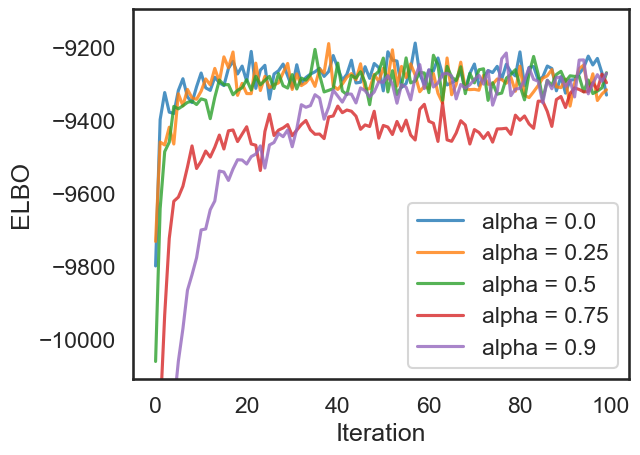

In [5]:
# Plot the ELBOs
q_elbos = []
for alpha in alphas:
    _,_,q_lem_elbos,_,_,_ = results[(alpha)]
    q_elbos += [q_lem_elbos]
    plt.plot(q_lem_elbos[1:], label="alpha = {}".format(alpha), alpha=0.8)
plt.xlabel("Iteration")
plt.ylabel("ELBO")
q_max = np.array(q_elbos).max()
plt.ylim([q_max-0.1*np.abs(q_max),q_max+0.01*np.abs(q_max)])
plt.legend()

(0.0, 1000.0)

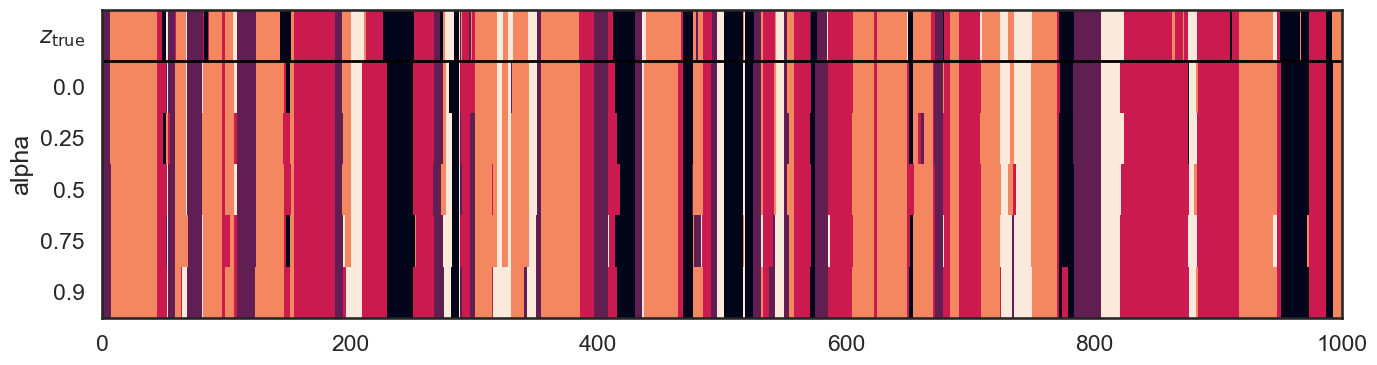

In [6]:
# Plot the true and inferred states
xlim = (0, 1000)

zs = []
for alpha in alphas:
    (_, _, _, _, q_lem_z, _) = results[(alpha)]
    zs += [q_lem_z]
    
plt.figure(figsize=(16,4))
plt.imshow(np.row_stack((z, zs)), aspect="auto", interpolation="none")
plt.plot(xlim, [0.5, 0.5], '-k', lw=2)
plt.yticks([0,1,2,3,4,5],["$z_{\\mathrm{true}}$", *alphas])
plt.ylabel("alpha")
plt.xlim(xlim)

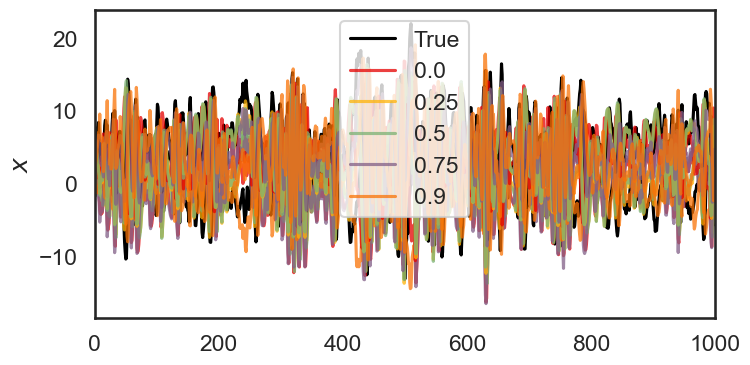

In [7]:
plt.figure(figsize=(8,4))
for d in range(D):
    plt.plot(x[:,d] + 4 * d, '-', color='k', label="True" if d==0 else None)
    for i, alpha in enumerate(alphas):
        _,_,_,q_lem_x,_,_ = results[(alpha)]
        plt.plot(q_lem_x[:,d] + 4 * d, '-',  color=colors[i+1], label=alpha if d == 0 else None, alpha=0.75)
plt.ylabel("$x$")
plt.xlim(xlim)
plt.legend()

(0.0, 1000.0)

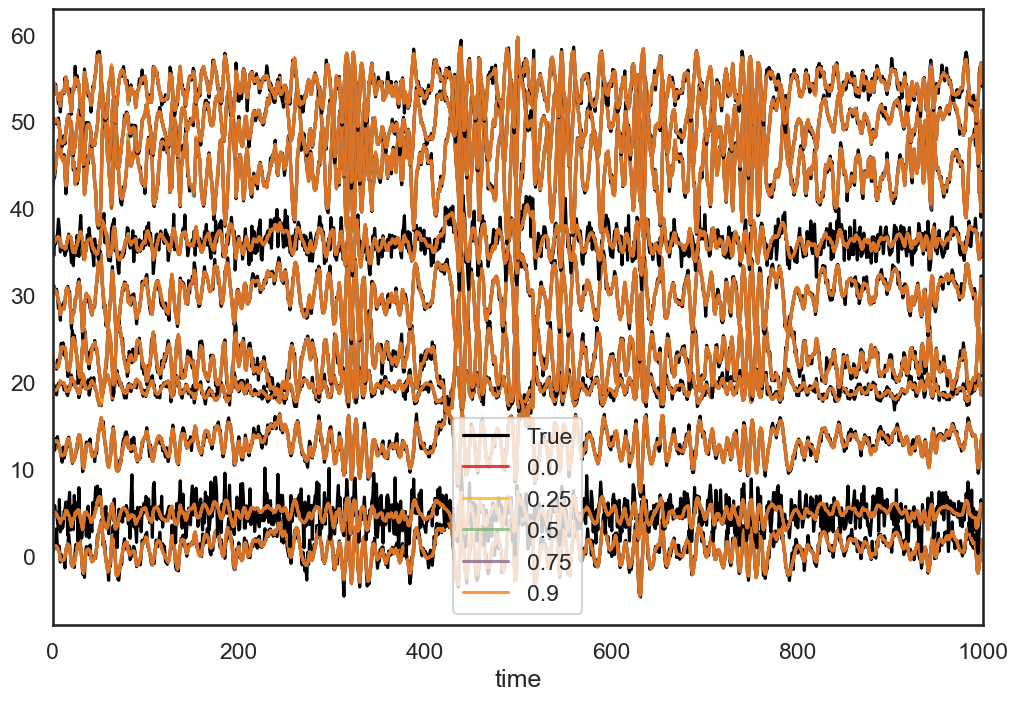

In [8]:
# Plot the smoothed observations
plt.figure(figsize=(12,8))
for n in range(N):
    plt.plot(y[:, n] + 6 * n, '-', color='k', label="True" if n == 0 else None)
    for i, alpha in enumerate(alphas):
        _,_,_,_,_,q_lem_y = results[(alpha)]
        plt.plot(q_lem_y[:,n] + 6 * n, '-',  color=colors[i+1], label=alpha if n == 0 else None, alpha=0.75)
plt.legend()
plt.xlabel("time")
plt.xlim(xlim)